# Строение CNN

Свёрточные нейронные сети обычно глубокие: в них не меньше десятка слоёв. Однако если рассмотреть разные архитектуры CNN, то все они состоят из двух частей: свёрточной и полносвязной. 

Свёрточная часть состоит из слоёв свёртки и пулинга и предназначена для поиска признаков на изображении. Пройдя через эти слои, изображение трансформируется в вектор признаков.

Вектор признаков — это найденные на изображении признаки, выраженные в виде чисел. К примеру, если в векторе 128 чисел, то:

- Первое может означать наличие или отсутствие на изображении кота. Чем больше число — тем кот более заметен.
   
- Второе — насколько красные объекты на фото. Чем число больше, тем больше красных объектов.
    …и так далее.

Причём только нейросеть знает, какое число за какой признак отвечает — для разработчика это непрозрачно.

Полносвязная часть состоит из полносвязных слоёв и принимает решение, основываясь на векторе признаков. Она работает по правилам обычного многослойного перцептрона (MLP): получает на вход числовые признаки, выдаёт результат решения задачи. Её архитектура выбирается по обычным правилам для MLP.

## Классификация

>**Классификация** — это отнесение изображения к одному или нескольким классам из заданного списка. Например:

- определение марки автомобиля по фото;
  
- распознавание рецепта по фото блюда;

- распознавание названия цветка по фото.

Целевая переменная для задачи классификации — это **метка класса.**

Датасеты для классификации состоят из пар «изображение — класс». MNIST — типичный пример датасета для классификации.

Класс обычно представляется в one-hot encoding (унитарное кодирование) — как вектор нулей с одной единицей на позиции, соответствующей номеру класса. Длина вектора — количество классов. Примеры:

- [0, 0, 1, 0] — означает класс 2 из четырёх возможных;
  
- [1, 0, 0] — это класс 0 из трёх возможных.

Это удобно, потому что можно интерпретировать числа как вероятность принадлежности изображения классу: 1 — 100% является этим классом, 0 — 0%, точно не является этим классом.

Соответственно, модель должна выдавать вектор такого же типа на выходном слое. Для этого в выходном слое должно быть столько нейронов, сколько классов в задаче. Например, если классов 10, то нужен слой nn.Linear(N, 10), где N — количество признаков в векторе, полученном из свёрточной части.

Чтобы значения результатов выходного слоя были в интервале [0, 1], к нему нужно добавить одну из типичных функций активации для задачи классификации: nn.Sigmoid() или n.Softmax(dim=1).

- **nn.Sigmoid()** используется для бинарной классификации или случаев, когда одному изображению может соответствовать несколько классов. Эта функция для каждого переданного в неё значения возвращает число в интервале [0, 1].

- **nn.Softmax(dim=1)** используется для остальных видов классификации. Эта функция сначала для каждого переданного значения рассчитывает nn.Sigmoid(), а затем нормализует вектор результата, то есть делит его на сумму его значений. В результате получается вектор типа [0.7, 0.2, 0.1] — каждое число лежит в интервале [0, 1] и при этом сумма всех чисел равна 1. Если округлить все числа, получится как раз вектор [1, 0, 0] — такого же вида, как целевой. Именно поэтому для функции указывается dim=1. Это обеспечивает нормализацию по изображениям: для каждого входного изображения получится вектор классов с суммой, равной 1. В противном случае была бы нормализация по классам: сумма значений класса по всем изображениям была бы 1, что бессмысленно.

Типичная архитектура CNN для классификации, если опустить свёрточную часть, выглядит так:

```python
import torch.nn as nn
model = nn.Sequential(
          # Здесь свёрточная часть, которая возвращает вектор с 512 признаками
          nn.Linear(512, 10),
          nn.Softmax(dim=1),
        )
```

## Детекция

Детекция, или детектирование, — это определение местоположения объекта на изображении. Например:

- подсчёт посетителей магазина по кадрам с видеонаблюдения;
   
- отслеживание питомца на кадрах с видеонаблюдения;
  
- распознавание координат машины в потоке, чтобы рассчитать её скорость и оштрафовать нарушителей.

Обычно результат решения задачи — координаты прямоугольника, в который вписан объект. Такой прямоугольник называется ограничивающим боксом или bounding box, bbox.

Соответственно, датасет для детекции состоит из пар «изображение — список боксов». Известный пример — датасет COCO.

В датасете боксы могут быть представлены в разных форматах:

- координаты левого верхнего и нижнего правого углов;

- координаты центра + ширина и высота;

- координаты верхнего левого угла + ширина и высота.

Однако это всегда 4 числа, достаточные, чтобы задать прямоугольник. Для передачи боксов в модель в качестве целевой переменной, они преобразуются в формат [cx , cy, w, h], где:

- cx — координата центра бокса по горизонтали (оси X),
  
- cy — координата центра бокса по вертикали (оси Y),
   
- w — ширина бокса,
    
- h — высота бокса.

Тогда для детектирования одного объекта на изображении полносвязная часть архитектуры может выглядеть так:

```py
import torch.nn as nn
model = nn.Sequential(
          # Здесь свёрточная часть, которая возвращает вектор с 512 признаками
          nn.Linear(512, 512),
          nn.ReLU(),
          nn.Linear(512, 4)
        ) 
```
В ней 512 признаков анализируются одним полносвязным слоем с активацией ReLU, после чего выходной слой возвращает 4 числа, соответствующих координатам бокса. Современные детекторы устроены сложнее и содержат дополнительные ухищрения, чтобы искать объекты быстрее и меньше ошибаться, однако суть — предсказание бокса — остаётся такой же.

**Обратите внимание, что функция активации не используется, так как получаемые координаты ничем не ограничены и могут быть любым числом. Иногда используется nn.ReLU() на выходе, чтобы детектор не генерировал невозможные отрицательные координаты.**

>Если нужно находить несколько объектов, то количество нейронов выходного слоя умножается на количество объектов. Например, если один объект — это 4 нейрона, то два — это 8 нейронов и так далее. Поэтому архитектура моделей для детектирования сложнее и содержит больше параметров, чем для классификации.

## Сегментация

Сегментация — это определение на изображении групп пикселей, соответствующих объектам. Поэтому результат сегментации — это маска, равная по площади входному изображению. Значения маски соответствуют классу соответствующего пикселя на изображении. К примеру: 1 — объект, 0 — фон.

Датасеты для сегментации хранятся в формате «изображение — маска». Так как это более сложная задача, чем детекция, где достаточно приблизительного местоположения объекта, часто по датасетам для сегментации рассчитывают боксы и используют их в детекции. 

Упомянутый ранее COCO — это изначально датасет для сегментации: в нём объекты размечены именно масками, то есть указаны точные границы для каждого объекта.

Однако COCO легко использовать для детекции — достаточно рассчитать прямоугольник, в который вписывается маска объекта. Поэтому его используют и для детекции, и для сегментации, и это частая практика применения датасетов для сегментации.

В отличие от детекции и классификации модель должна выдавать не числа, а одноканальное изображение — маску. Полносвязные нейросети плохо справляются с передачей и анализом пространственного положения признаков на фото. Поэтому в архитектурах для сегментации полносвязной части нет, вместо неё ещё одна свёрточная.

Идея такова: из вектора признаков, полученного после первой свёрточной части, можно получить изображение, если использовать операцию, обратную свёртке. То есть архитектура сети для сегментации состоит из свёрточной и «развёрточной» частей.

«Развёрточная часть» состоит из операций upsampling (противоположность пулинга) и транспонированной свёртки (transposed-convolution). Несмотря на название, такая свёртка просто обратна обычной свёртке. Вместо того чтобы умножить фрагмент изображения на фильтр, суммировать и получить число, нужно умножить число на фильтр и получить фрагмент изображения.

Такие архитектуры значительно сложнее и подходят для узкого круга задач, поэтому в рамках этого модуля будут встречаться только самые популярные архитектуры — предназначенные для классификации.

# Классические архитектуры CNN



## LeNet

Нейронная сеть LeNet предназначалась для распознавания рукописных цифр от 0 до 10. Авторы активно развивали свою идею, поэтому она существует в пяти версиях: от прототипа LeNet-1 до развитой LeNet-5, точность которой составляет 98.4%. Говоря о LeNet, исследователи имеют в виду именно пятую — лучшую — версию.

Ниже представлена более подробная схема, по которой можно реализовать архитектуру самостоятельно. Разработчики чаще всего поступают именно так — используют проверенные научным сообществом архитектуры вместо того, чтобы создавать собственные с нуля.

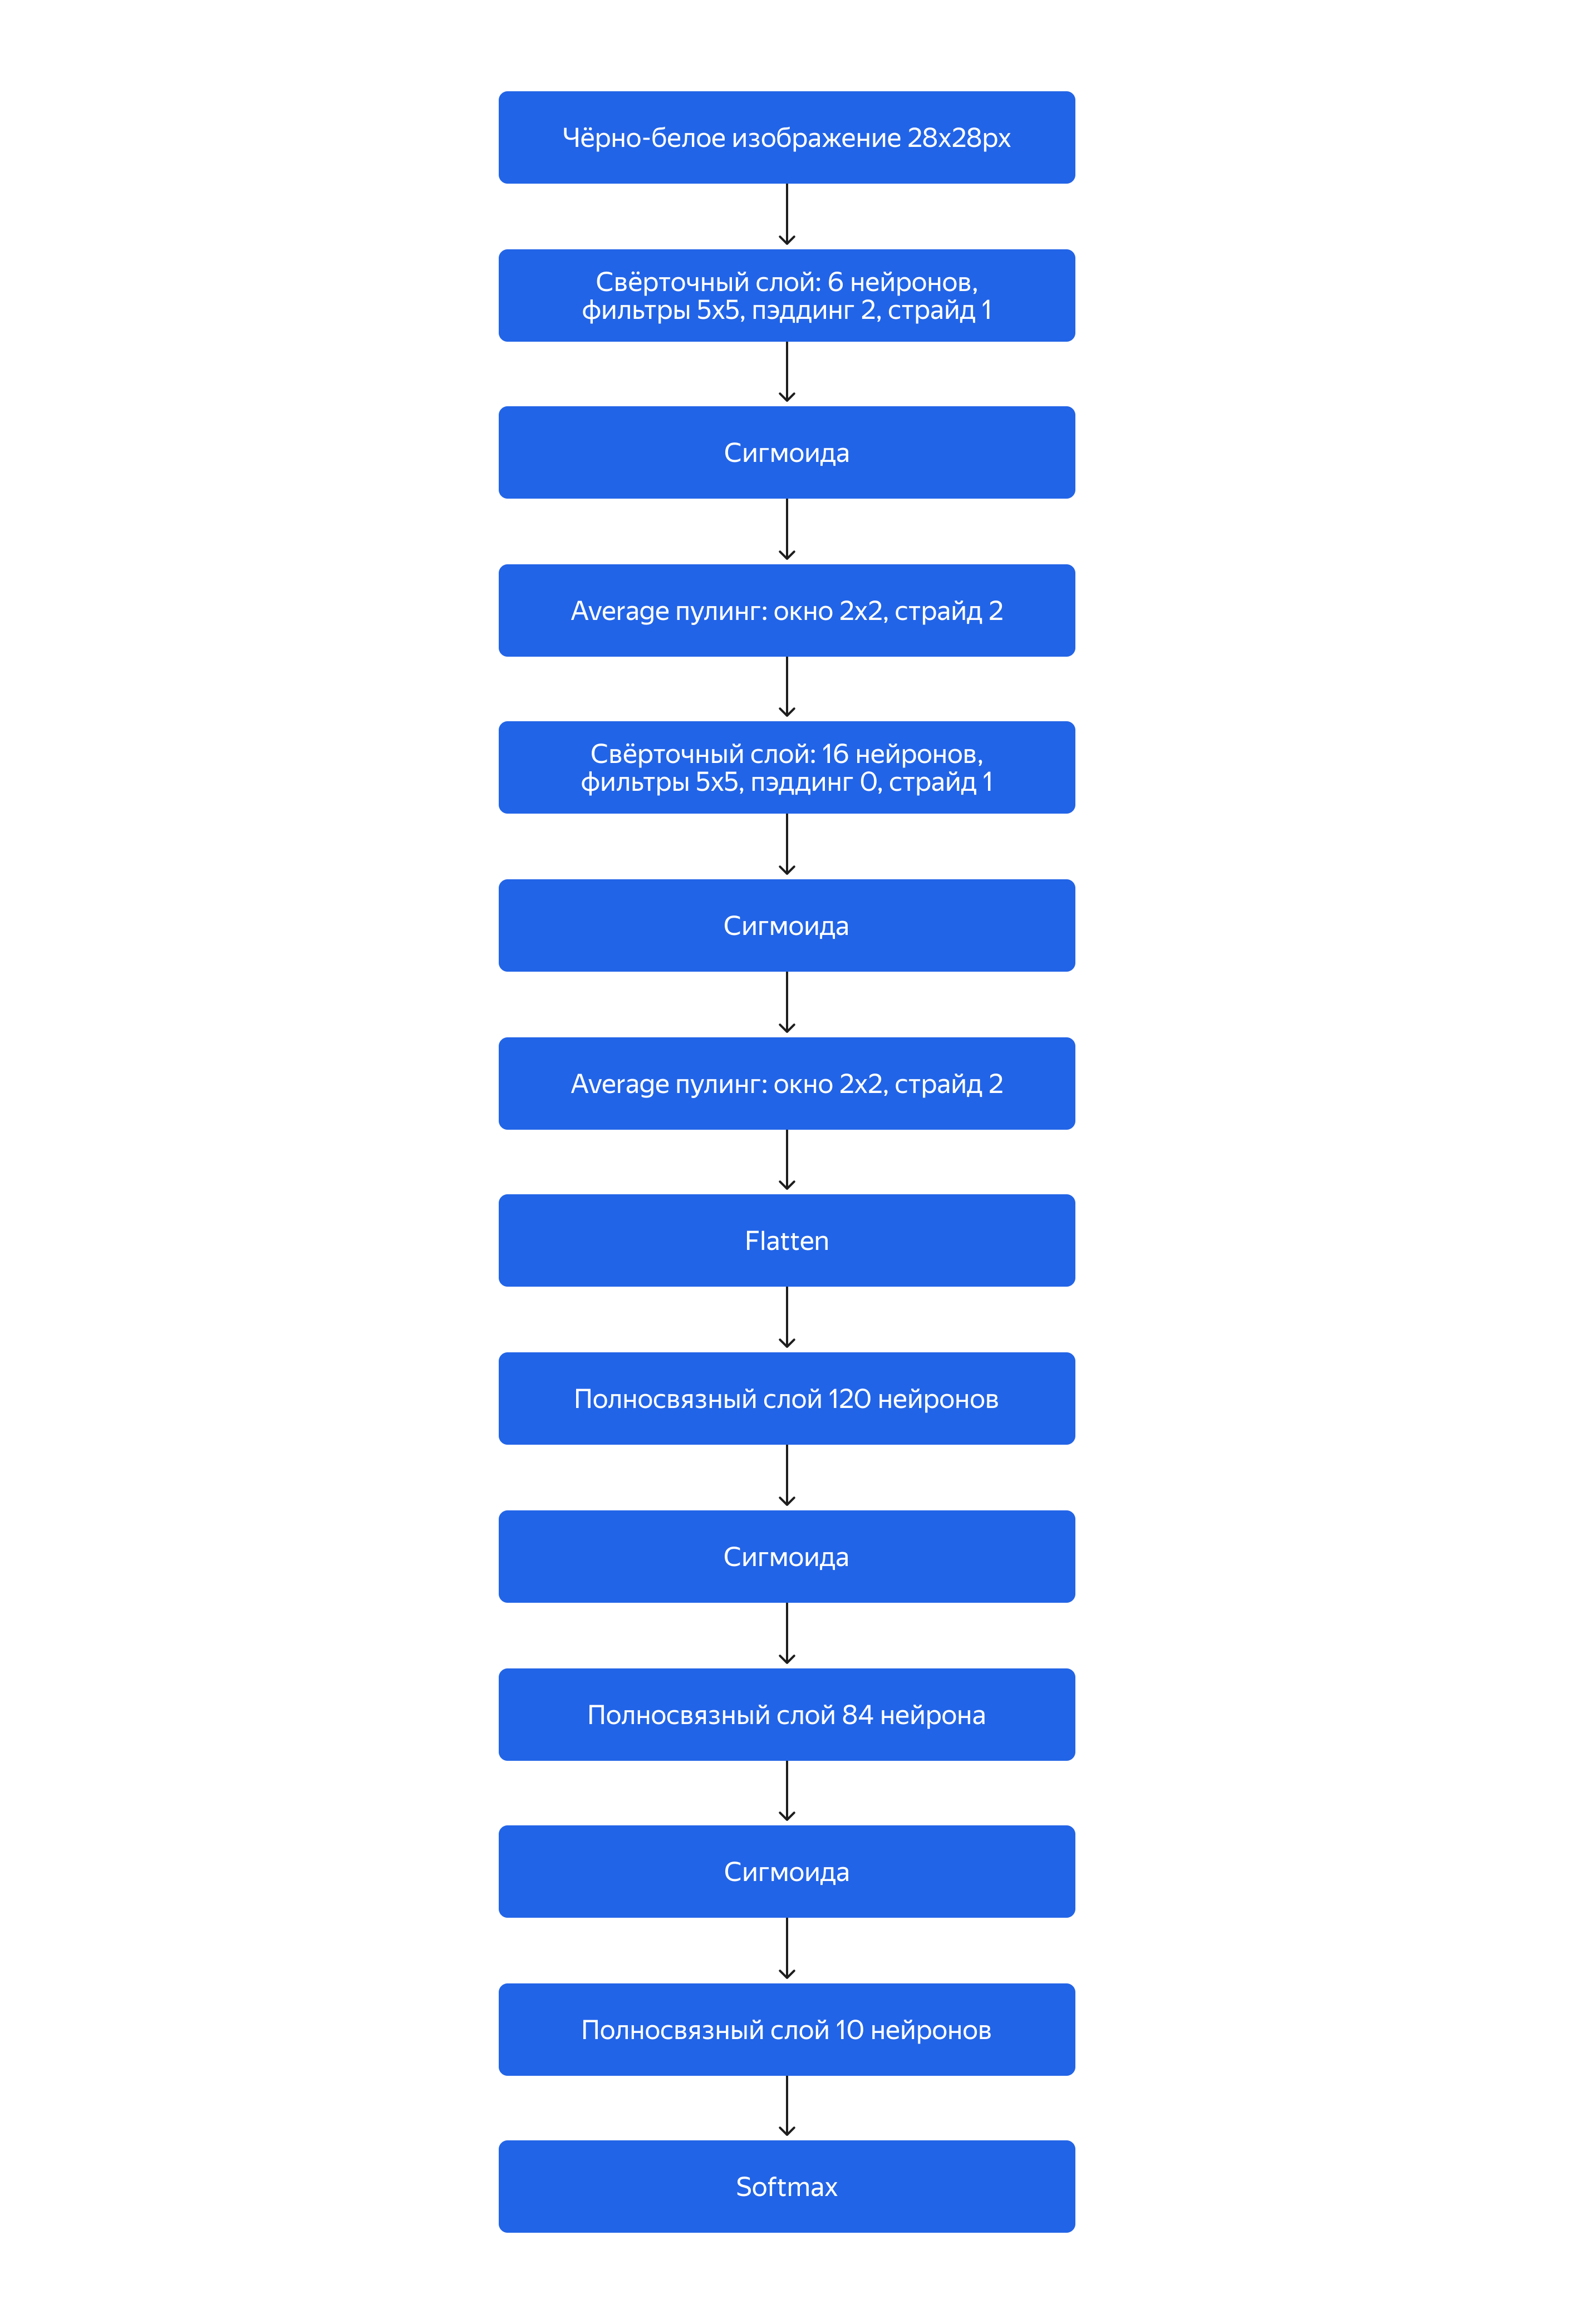

In [2]:
from IPython.display import Image
from ml_dl_experiments.settings import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/LeNet5.png"
Image(path_to_image, width=500, height=500)

LeNet состоит из знакомых слоёв: свёрточных, пулинга, полносвязных. Они перемежаются функциями активации: сигмоидой, Softmax, и преобразования в плоский вектор — Flatten. Рассмотрим подробнее детали архитектуры, на которые стоит обратить внимание:

- Дважды повторяется последовательность «свёртка → функция активации → пулинг». После каждого такого блока площадь тензора становится меньше, а глубина — больше. Идея постепенно сокращать ширину и высоту, но наращивать количество карт признаков до сих пор актуальна. Функция активации посередине включает в вычисления нелинейность, что позволяет обнаруживать более сложные признаки. Последовательность слоёв «свёртка-пулинг» называется свёрточный блок.
  
- Фильтры 5×5 в свёрточных слоях — начиная с LeNet закладывается идея о небольшом размере фильтров.

- Количество нейронов в свёрточных слоях постепенно растёт от входа к выходу модели. Это позволяет постепенно увеличивать количество обнаруженных признаков и тоже используется в современных архитектурах.

- Количество нейронов в полносвязных слоях уменьшается от входа к выходу модели. Кажется логичным, что это лучше, чем резкий переход от 120 нейронов к 10, но справедливость этого подхода не была доказана, поэтому используется не всегда.

- Сигмоида — это ещё не современная сигмоида, а скорее подвид гиперболического тангенса, но её роль в вычислениях та же — вносить нелинейность.

Архитектуру LeNet можно обобщить как: свёрточная часть + полносвязная. Свёрточная часть состоит из нескольких последовательных свёрточных блоков.

Архитектуру LeNet можно реализовать самостоятельно с помощью PyTorch. Для этого нужно повторить порядок слоёв, описанный на изображении выше. Они расположены последовательно, поэтому можно использовать объект nn.Sequential(). 

```python
import torch.nn as nn

model = nn.Sequential(
    # Первый сверточный блок
    nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
    nn.Tanh(), # Сигмоидальная функция, похожая на используемую в LeNet
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    # Второй сверточный блок
    nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),

    #Полносвязная часть
    nn.Linear(400, 120),
    nn.Tanh(),
    nn.Linear(120, 84),
    nn.Tanh(),
    nn.Linear(84, 10),
    nn.Softmax(dim=1)
)
```

## AlexNet

AlexNet соответствует общей логике свёрточных нейросетей: за свёрточной частью следует полносвязная. Поэтому рассмотрим детали, отличающие её от предшественников:

- Она работает с цветными изображениями, размер входа и количество нейронов увеличились и соответствуют небольшим современным моделям.
    
- Сигмоида-гиперболический-тангенс заменена на новую функцию — ReLU, которую удобнее рассчитывать и которая немного помогает решить проблему исчезающего градиента, так как выдаёт значения не в интервале от 0 до 1, как сигмоида, а в [0,+∞).
    
- Появился Dropout — техника, основанная на идее случайного отключения части нейронов во время обучения, чтобы нейросеть не полагалась только на конкретные нейроны или признаки.

- Average пулинг заменён на макс-пулинг.
    
- Свёрточные блоки всё ещё есть, но в одном из них несколько свёрточных слоёв подряд перед одним пулингом — эта идея тоже актуальна и в современных моделях.
    
- Количество нейронов в полносвязных слоях не уменьшается от входа к выходу, как и в современных архитектурах.

Идеи, которые не прижились:

- Увеличение, а потом уменьшение количества нейронов в свёрточных слоях.
    
- Фильтры 11×11 и их постепенное уменьшение.
    
- 3×3 макс-пулинг со страйдом 2.

LeNet и AlexNet похожи между собой, а также на современные архитектуры нейросетей, потому что повлияли на дальнейшие разработки.

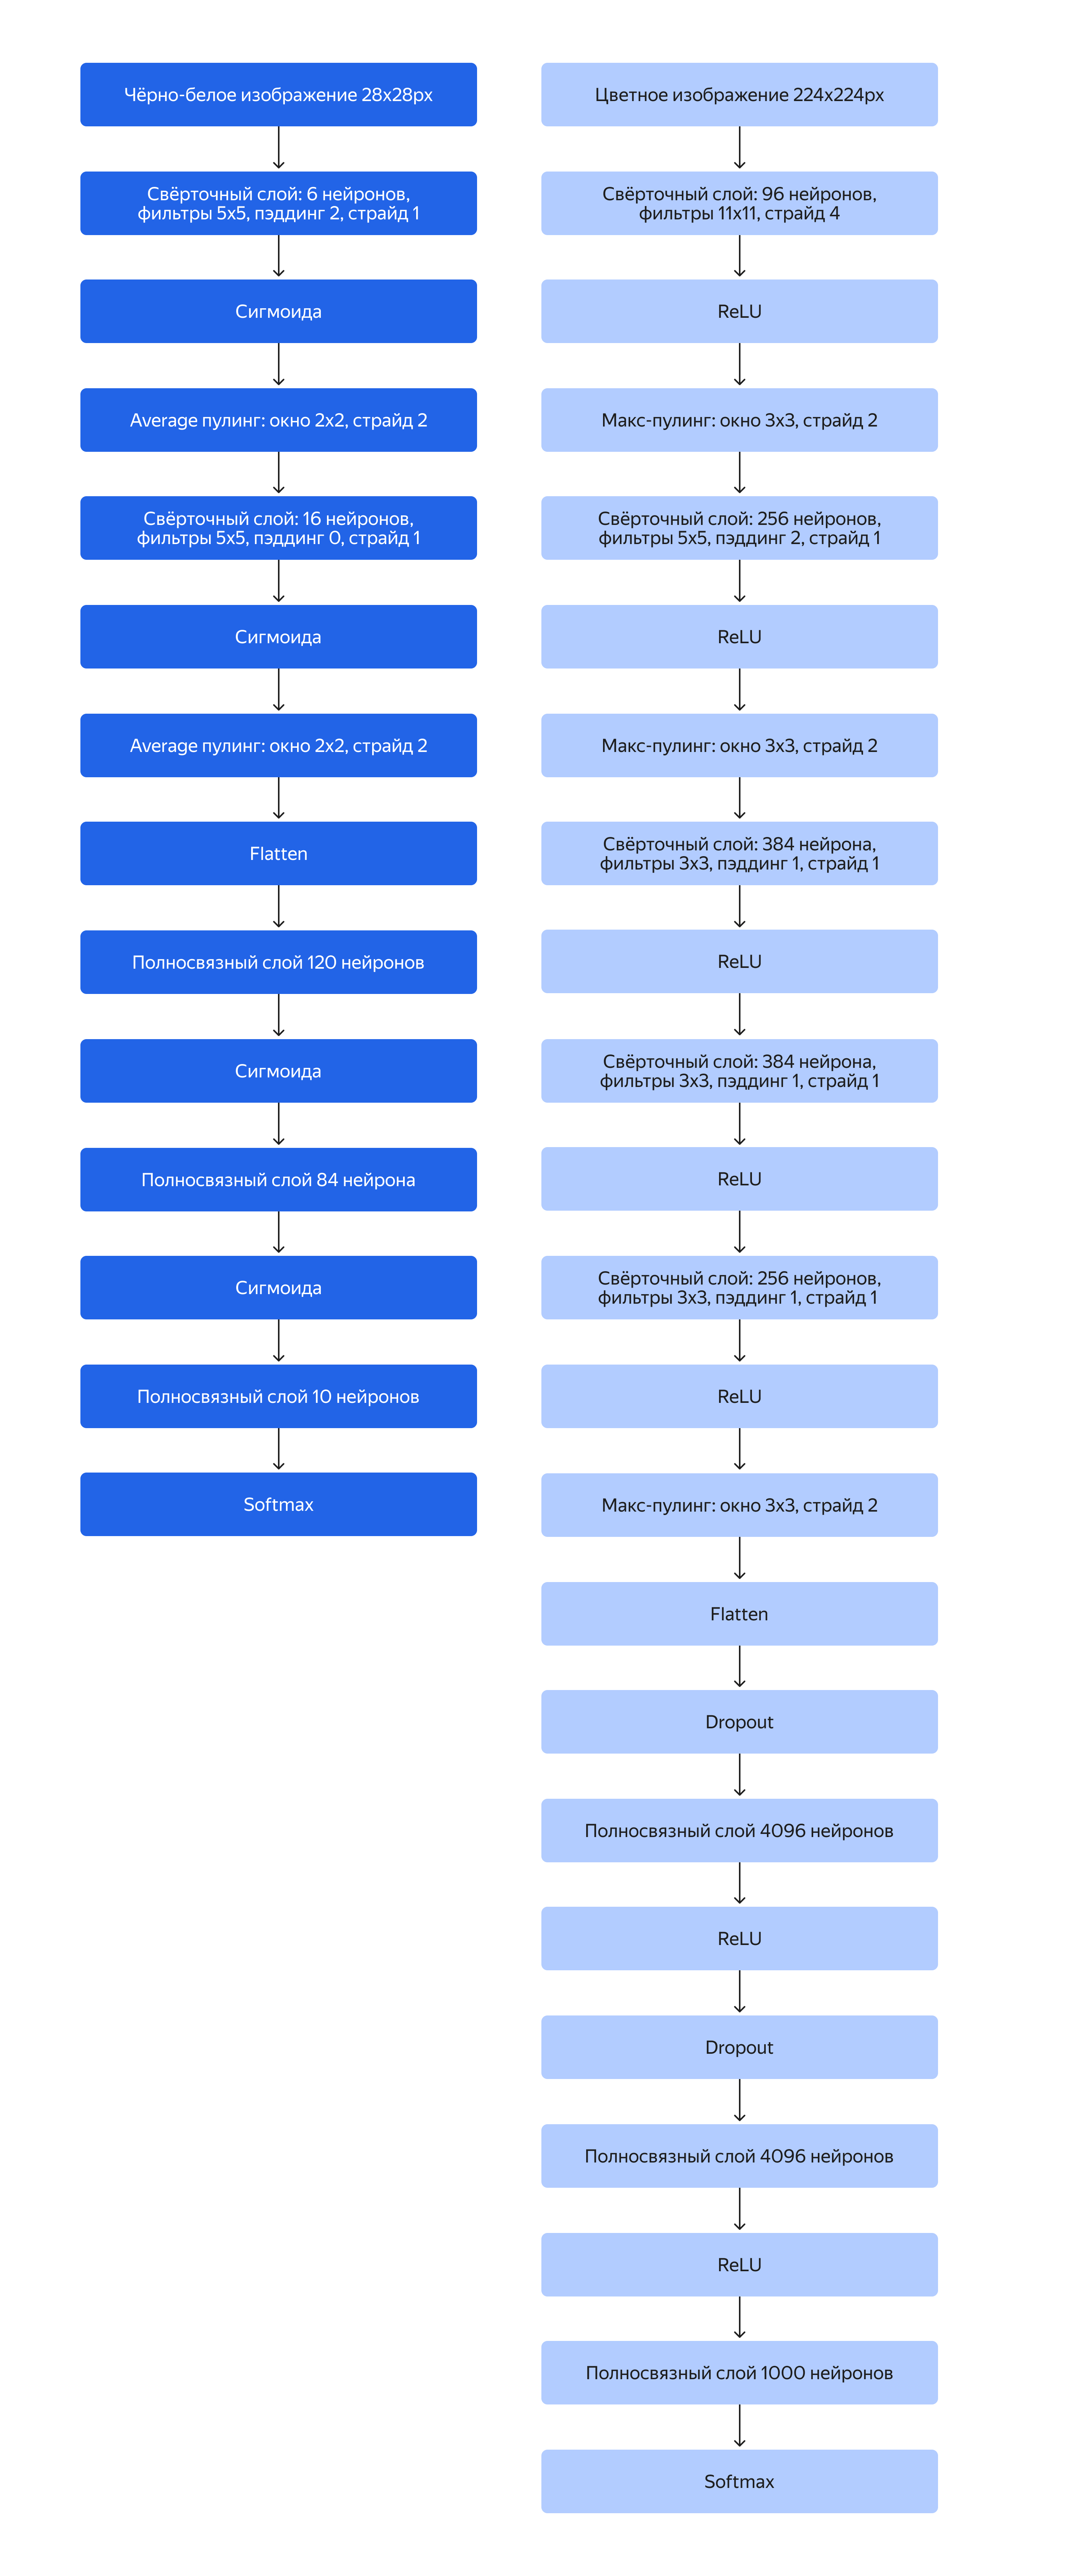

In [5]:
path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/LeNet5vsAlexNet.png"
Image(path_to_image, width=700, height=700)

In [11]:
import torch.nn as nn

# Используйте архитектуру LeNet в качестве основы
model = nn.Sequential(
    # input - colored image 224*224px
    # Первый свёрточный блок
    nn.Conv2d(3, 96, kernel_size=11, stride=4),
    nn.ReLU(), # Сигмоидальная функция, похожая на используемую в LeNet
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 96 * 28*28 + 96
    
    # Второй свёрточный блок
    nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 256 * 13*13 + 256
    # сверточный блок без пуллинга:
    nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 256 * 6*6 + 256
    
    nn.Flatten(),
    # 1*9216
    nn.Dropout(p=0.3),

    #Полносвязная часть
    nn.Linear(9216, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1000),
    nn.Softmax(dim=1)
)

print("Архитектура модели:", model)
print("Количество параметров:", sum(p.numel() for p in model.parameters()))

Архитектура модели: Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Dropout(p=0.3, inplace=False)
  (15): Linear(in_features=9216, out_features=4096, bias=True)
  (16): ReLU()
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Linear(in_features=4096, out_features=1000, bias=

In [12]:
# вычисление на flatten
print(256*6*6)

9216


## VGG

Её точность на том же датасете ImageNet — 76.3%, и это последний резкий скачок качества между архитектурами. В последующие годы сети будут потихоньку улучшаться менее чем на 3% в год, поэтому VGG применяется до сих пор.
VGG существует в двух версиях: VGG-16 и VGG-19. 

Число обозначает количество обучаемых слоёв. Версии практически идентичны, поэтому рассмотрим «младшую» VGG-16. Так как размер VGG существенно больше предыдущих моделей, рассмотрим её схематично.

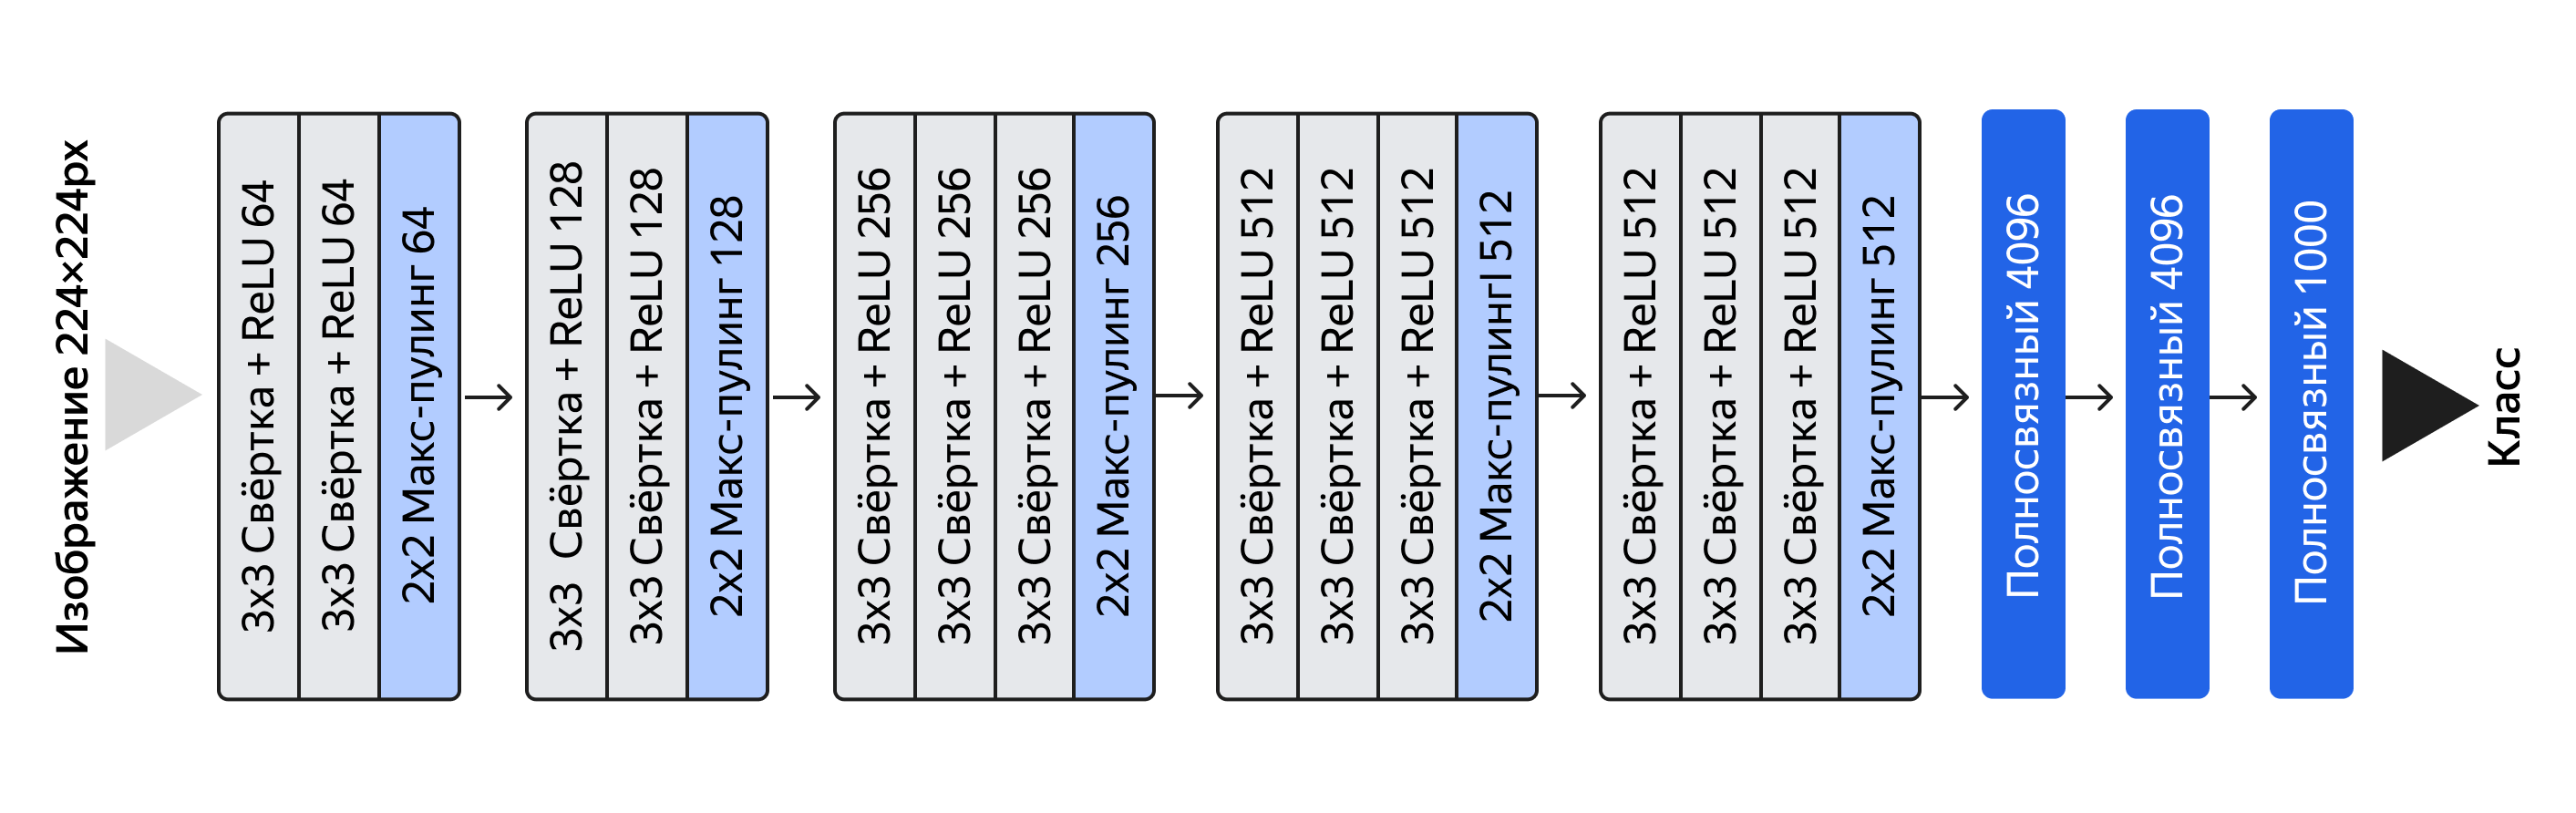

In [13]:
path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/vgg.png"
Image(path_to_image, width=700, height=700)

Рассмотрим её детальнее:

- Свёрточные блоки активно используются, их количество растёт.
  
- Окончательно прижилась идея располагать несколько свёрточных слоёв перед одним пулингом.
  
- Свёртки уменьшены до 3×3 — неважно, слой находится в начале нейросети или ближе к выходу.

- Макс-пулинг уменьшен до 2×2 со страйдом 2.

- От входа к выходу возрастает количество нейронов в свёрточных слоях и, соответственно, количество карт признаков.

Все эти идеи легли в основу современных моделей. Проектируя собственную архитектуру, разработчик опирается на эти вводные, потому что их результативность проверена.

Архитектуры такого размера редко проектируются с нуля самостоятельно, обычно разработчики или используют авторскую реализацию с GitHub, или модифицируют похожую модель, или используют встроенные в библиотеки функции, автоматически создающие требуемую архитектуру, например `torchvision.models.vgg16().`

## ResNet

Прежде серьёзной проблемой, ограничивающей рост нейронных сетей, были исчезающий или взрывающийся градиенты. Нейронные сети обучаются с помощью метода обратного распространения ошибки, в котором используется градиентный спуск. Он подразумевает умножение — причём чем глубже нейросеть, тем больше умножений. В итоге получается, что:

- Если значения весов и ошибки слишком большие, то в результате многократного умножения значение градиента начнёт резко возрастать от слоя к слою и может привести к переполнению разрядной сетки. Это взрывающийся градиент — с ним проще бороться, достаточно инициализировать веса околонулевыми значениями и нормализовать входные данные.
  
- Если значения весов и ошибки меньше 1 по модулю, то в результате многократного умножения значение градиента будет постепенно приближаться к нулю и веса практически перестанут меняться в процессе обучения. Это исчезающий градиент, и с ним справиться сложнее.

Частично решить проблему исчезающего градиента помогли промежуточные слои нормализации в моделях, о них пойдёт речь в следующем уроке. Однако осталась ещё одна проблема — постепенная потеря входных признаков в процессе углубления модели. 

Проходя через множество слоёв, признаки становятся всё более абстрактными. Мелкие детали, изначально переданные в модель, исчезают к моменту перехода к полносвязным слоям. Это вызывало проблему плата точности — когда с увеличением количества слоёв точность модели не улучшается или начинает падать, потому что данные становятся слишком абстрактными.

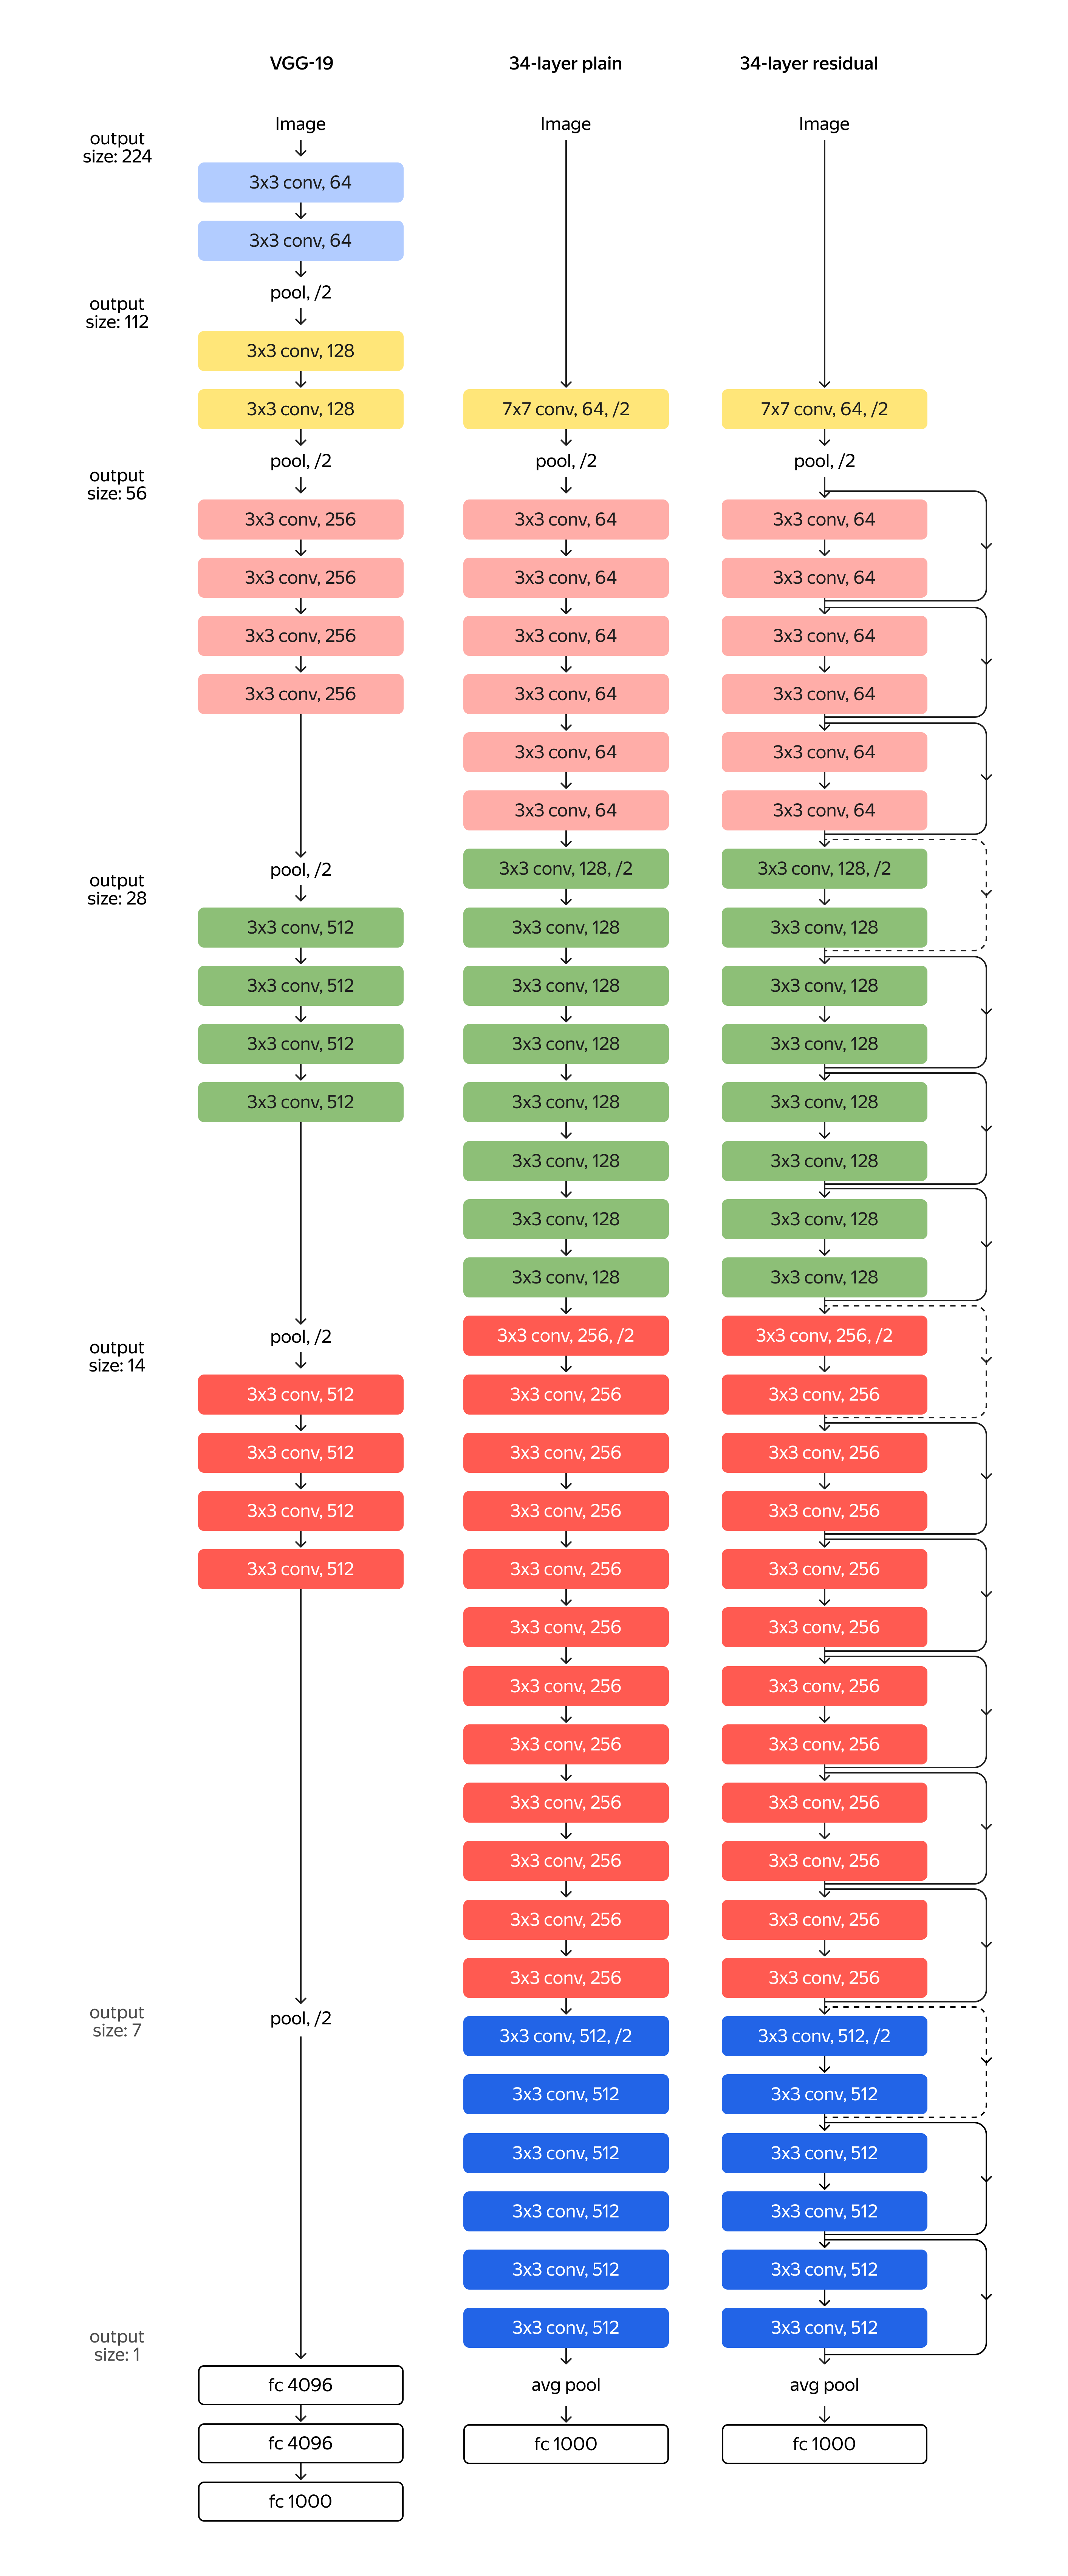

In [14]:
path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/vgg19vsResNet.png"
Image(path_to_image, width=700, height=700)

Авторы демонстрируют свою идею так:

- Вот знакомая архитектура VGG-19 — свёрточные блоки перемежаются пулингом, в конце несколько полносвязных слоёв.
  
- Вот более глубокая архитектура, которую предлагают авторы. В ней очень много слоёв свёртки, пулинга всего 2 — в начале и в конце. Полносвязный слой всего один — чисто выходной под нужное количество классов. Однако такая архитектура работать не будет, потому что она слишком глубокая и подвержена как плато точности, так и исчезающему градиенту.
  
- Вот residual network от англ. residual — остаточный, то есть архитектура с остаточными связями. В ней есть дополнительные чёрные стрелки, огибающие часть слоёв. Они означают передачу данных неизменёнными, в обход нескольких слоёв.

В итоге в архитектуре ResNet есть три новых элемента, которые делают её лучше.
Свёрточные блоки с остаточными связями (residual блоки). Эти остаточные связи часто называют skip-connection или shortcut, потому что они позволяют пропустить часть слоёв и передать данные в более поздние слои неизменными. 

Главная его особенность в том, что признаки копируются в две параллельные ветки вычислений. В первой ветке они проходят через несколько слоёв обработки, во второй с ними ничего не происходит. В конце обе ветки снова сливаются в одну — обработанные и изначальные признаки суммируются.


1. **Замена нескольких полносвязных слоёв на один слой глобального пулинга.** Он сокращает площадь карт признаков до 1x1, окончательно устраняя информацию о местоположении признаков. Ранее это достигалось за счёт цепочки свёрточных блоков или слоя Flatten. С помощью глобального пулинга получилось:

- Сократить количество обучаемых параметров.
   
- Улучшить итоговую точность по сравнению с VGG с 76.3 до 80.1% на датасете ImageNet. Это удалось сделать за счёт более удачной архитектуры свёрточной части и более качественных признаков, извлечённых из изображения.

2. **Использование свёртки со страйдом 2 в первом слое.** Это позволяет сразу сократить в 4 раза площадь входного тензора. Для сравнения — в VGG уменьшение площади происходило медленнее и только за счёт пулинга.

Здесь же происходит использование свёртки с таким страйдом вместо пулинга, что позволяет продолжать снижать площадь карт признаков. Сокращение площади тензора ускоряет дальнейшие вычисления ценой удаления информации о местоположении признаков, которая всё равно не понадобится в последних — полносвязных — слоях.

## Skip-connections:

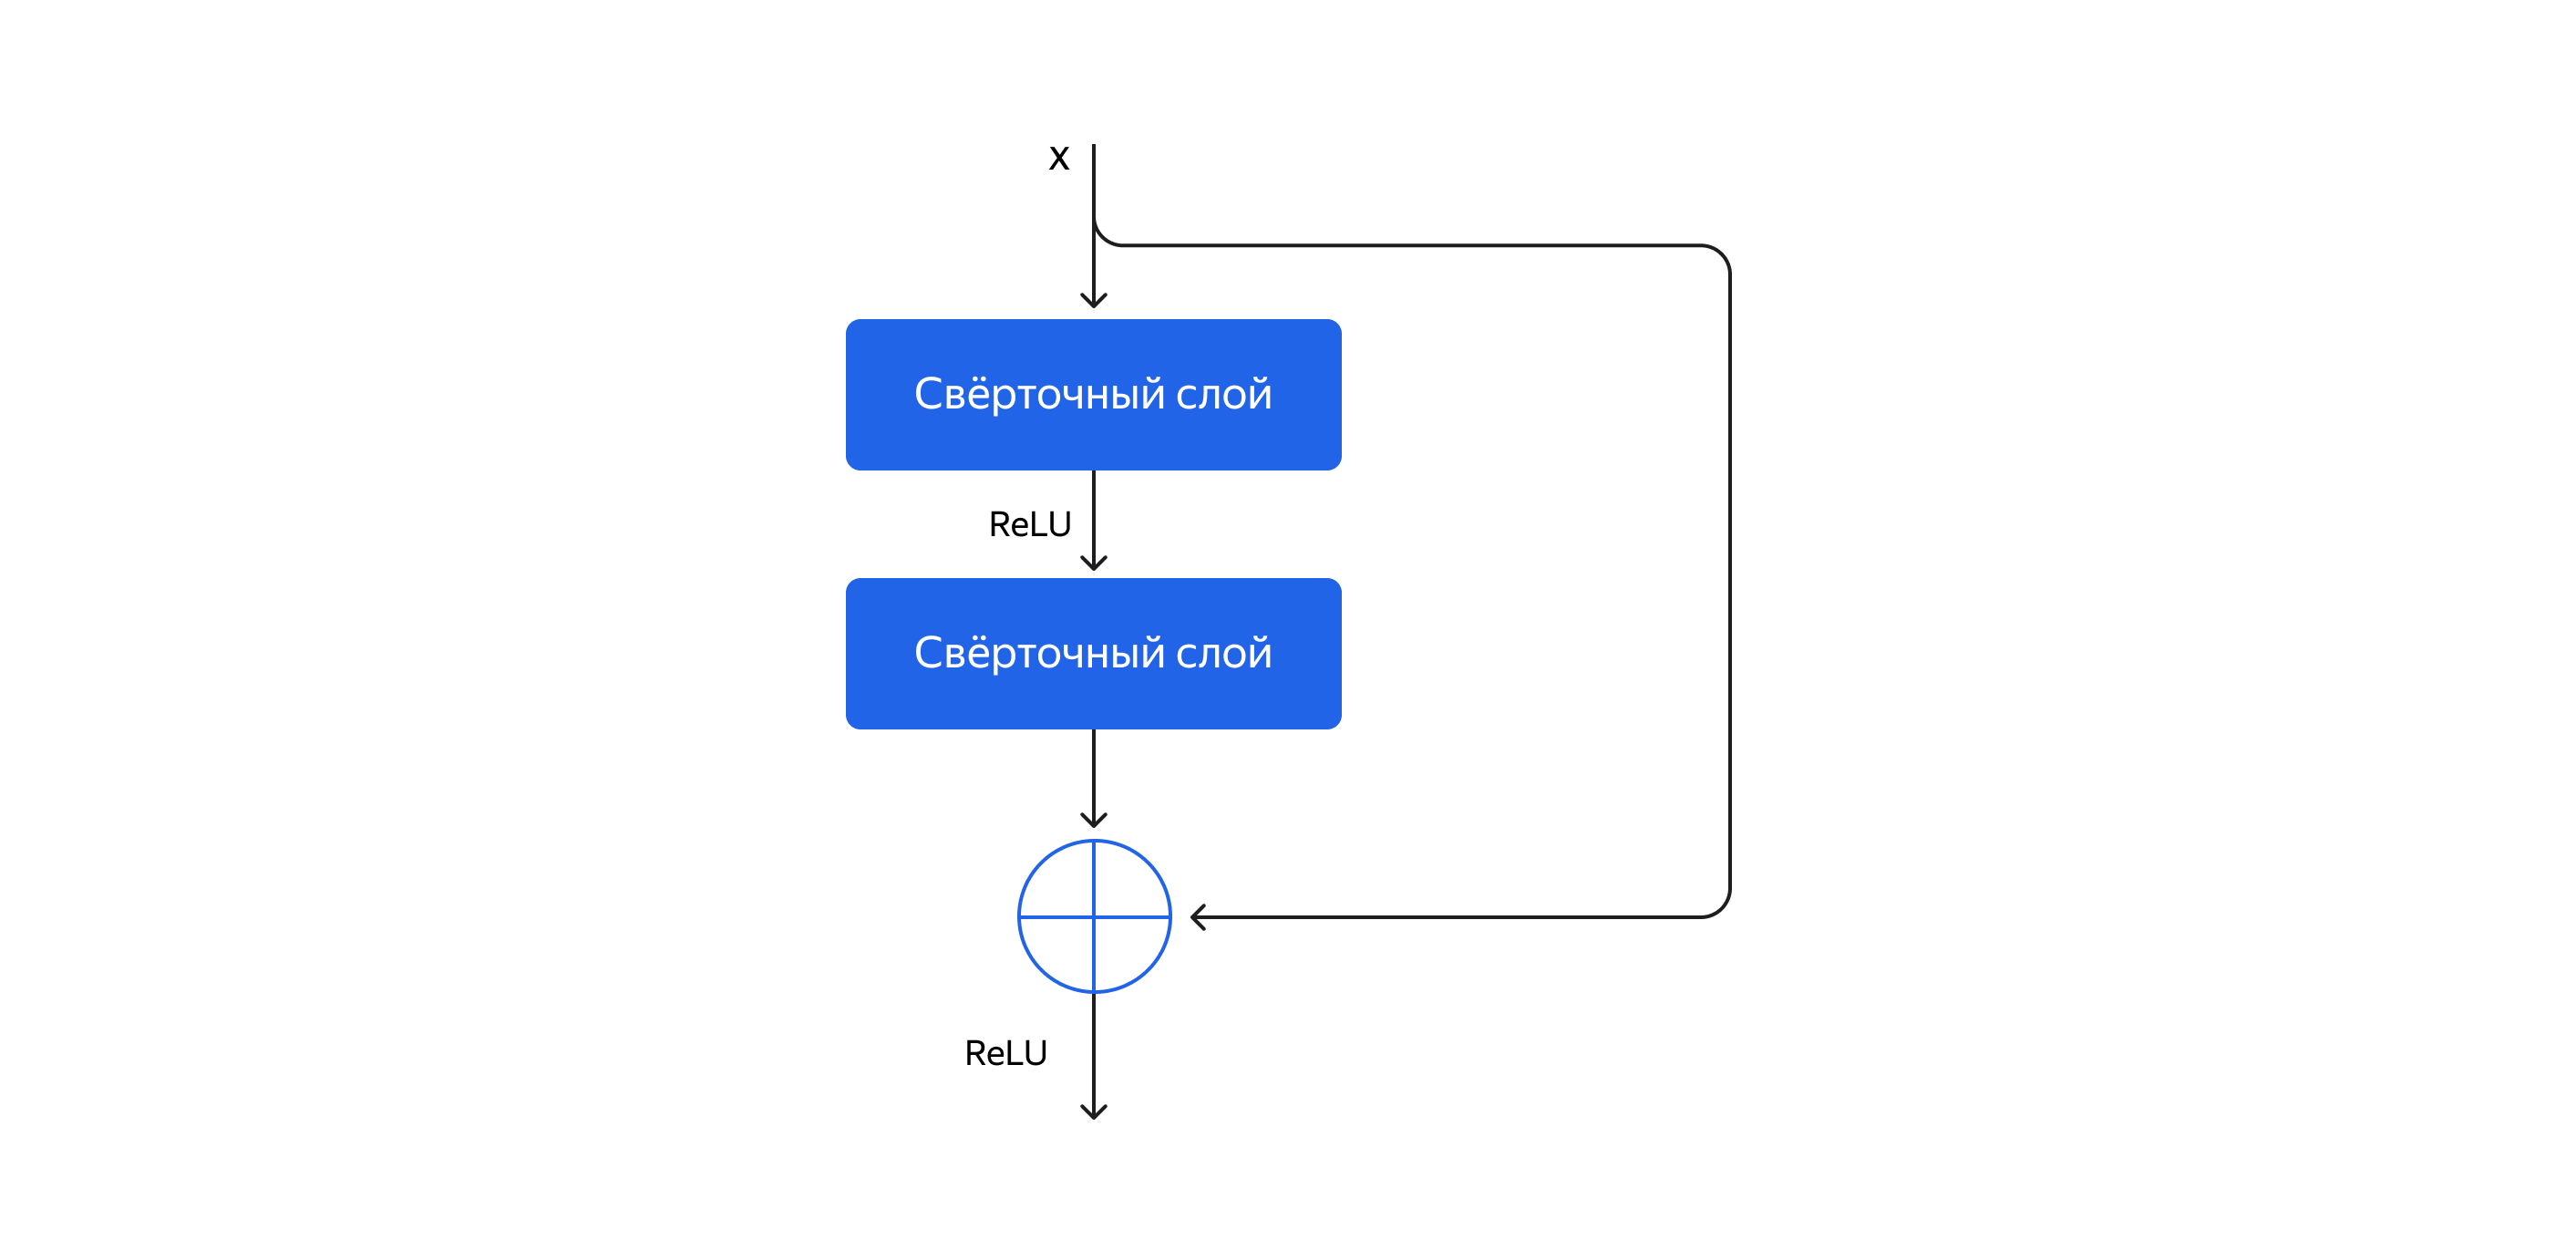

In [15]:
path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/residual_block.png"
Image(path_to_image, width=700, height=700)

1. В первой ветке X проходит через два свёрточных слоя и активацию между ними, получается X_после_свёртки.
   
2. Во второй ветке — той самой skip-connection — X просто передаётся дальше, никак не меняясь.

После этого X и X_после_свёртки суммируются. Чтобы суммирование прошло корректно, размерности X и X_после_свёртки должны полностью совпадать. Поэтому если в X три канала, то второй слой свёртки обязательно должен иметь три нейрона, чтобы из них получалось только три карты признаков. Если глубина X = 64, то второй слой свёртки должен выдавать 64 карты признака соответственно. 

Все свёртки должны быть с пэддингом same, чтобы не только глубина, но и площадь тензора не менялись. 

Вот как skip-connections решают проблемы глубоких нейросетей:

- Повторное использование признаков — когда признаки становятся слишком абстрактными, они обновляются неизменёнными признаками, поступившими по ветке skip-connection. Это решает проблему плато точности.
  
- Обратное распространение ошибки — по skip-connections данные передаются не изменёнными, не домноженными на какие-либо веса. Значит, и ошибка распространяется от выхода модели к входу без «взвешивания». Это сокращает количество умножений, значения градиента не деградируют до околонулевых, и модель успешно обучается даже с большим количеством слоёв.

Чтобы лучше понять, насколько skip-connections влияют на обучение модели, взгляните на визуализацию из научной статьи:

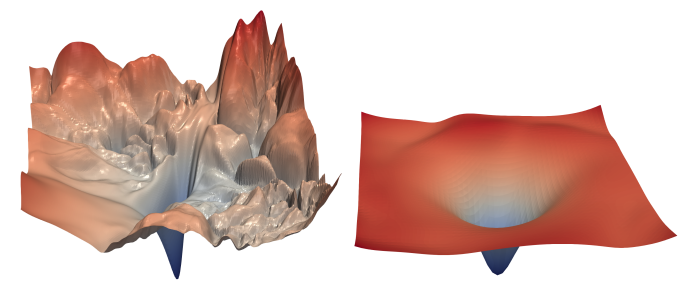

In [17]:
path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/without_and_with_residual_blocks.png"
Image(path_to_image, width=700, height=700)

Здесь изображена поверхность, упрощённо отражающая зависимость значения функции ошибки от весов модели ResNet. 

- Слева — поверхность для модели без skip-connections, справа — с ними. На левой поверхности огромное количество экстремумов — как минимумов, так и максимумов, сложно найти тот самый истинный минимум, самую глубокую точку, не застряв в этом ландшафте. 

- При этом на поверхности справа хоть и есть небольшие выступы и впадины, найти на ней самую глубокую точку гораздо легче.

## Реализация ветвлений
В архитектуре residual-блока есть параллельные вычисления, когда данные копируются и вычисляются в разных ветках архитектуры. Такие конструкции называются ветвлениями, а сами архитектуры — разветвлёнными. В предыдущих уроках не встречались разветвлённые модели, поэтому рассмотрим механизм программирования таких архитектур.

До этого в примерах для создания моделей использовался объект nn.Sequential, потому что все слои располагались строго последовательно. Для реализации ветвлений придётся обратиться к другому способу создания архитектур — через nn.Module. При таком способе возможно создание нескольких параллельных веток вычисления, а слои связываются между собой через переменные. К примеру, последовательность «слой 1 → слой 2 → слой 3» выглядит так:
```python
x = cлой1(inputs)
x = слой2(x)
outputs = слой3(x)
```

Если нужно:

- Провести inputs отдельно через слой 1 — получить x1.
  
- Провести inputs отдельно через слой 2 — получить x2.
  
- Сложить x1 и x2, их сумму провести через слой 3.

То выглядит это так:
```py
x1 = слой1(inputs)
x2 = слой2(inputs)
x3 = x1 + x2
outputs = слой3(x3)
``` 

Для вышеприведённого residual блока удобно создать отдельный класс

ResidualBlock, так как он будет часто повторяться. В PyTorch встроенные слои, такие как Conv2d, — это модули, они наследуются от nn.Module. Кастомные блоки слоёв — это тоже модули, просто состоящие из подмодулей, соответственно, тоже наследуются от nn.Module. Нейронные сети — тоже модули с подмодулями, наследники nn.Module. Поэтому кастомный блок ResidualBlock тоже создаётся как класс, наследованный от nn.Module.

Далее в init прописываются слои, которые будут использоваться:

- self.conv1 = nn.Conv2d(inputs, outputs, kernel_size=3, stride=stride, bias=False, padding='same') — первый свёрточный слой.

- self.relu = nn.ReLU(inplace=True) — активация между слоями.
  
- self.conv2 = nn.Conv2d(outputs, outputs, kernel_size=3, stride=stride, bias=False, padding='same') — второй свёрточный слой.

После этого в функции forward(x) описывается порядок их применения:

- x сохраняется в переменную identity, чтобы потом провести эти данные по skip-connection.
  
- x проводится через свёрточный слой, активацию reLU и ещё один свёрточный слой. Результат заносится в out.
  
- К out добавляется ранее сохранённый неизменённый вход — identity.
    
- Результат проводится через активацию reLU.

```python
import torch.nn as nn
from torch import Tensor


class ResidualBlock(nn.Module):

    def __init__(
        self,
        inputs: int,
        outputs: int,
        stride: int = 1,
    ) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(inputs,
                               outputs,
                               kernel_size=3,
                               stride=stride,
                               bias=False,
                               padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(outputs,
                               outputs,
                               kernel_size=3,
                               stride=stride,
                               bias=False,
                               padding='same')

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.relu(out)

        out = self.conv2(out)

        out += identity
        out = self.relu(out)

        return out
```

In [1]:
from ml_dl_experiments.dl.dl_modules.CNN.residual_block import ResidualBlock

print("Архитектура модели:", ResidualBlock(256, 64, 256))

Архитектура модели: ResidualBlock(
  (conv1): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
  (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
)


## Bottleneck
В residual блоках ResNet есть неудобство: размерность тензора на выходе из блока должна быть равна размерности тензора на входе, чтобы операция поэлементного суммирования работала. Из-за этого нет возможности сокращать площадь тензора внутри свёрточного блока, как это было в архитектурах-предшественниках. 

Поэтому в момент, когда по нейросети движутся 256 или даже 512 карт признаков, количество параметров в свёрточных блоках сильно возрастает. Это проблема, потому что вычислительная сложность, вес и время работы модели значительно увеличиваются. Чем больше блоков, тем сильнее эта проблема проявляется.

Поэтому в ResNet были предложены bottleneck-блоки вместо обычных свёрточных. Они называются так из-за сходства с бутылочным горлышком (резкое сужение, затем расширение) и выглядят вот так:

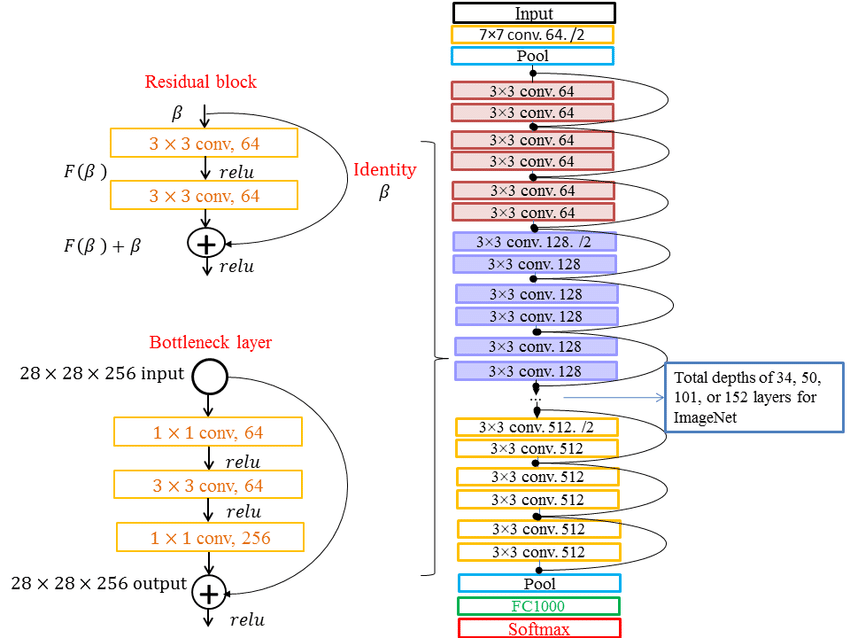

In [2]:
from IPython.display import Image
from ml_dl_experiments import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/blocks.png"
Image(path_to_image, width=700, height=700)

Идея bottleneck блока такова:

- Входной тензор размера W×H×256 словно втискивается в бутылочное горлышко — сжимается до компактного размера W×H×64 с помощью операции свёртки с 64 фильтрами размера 1×1.
    
- Над компактным тензором проводится стандартная операция свёртки, получается 64 признака. Ключевое здесь - padding=1. Без него не сойдется сумма ширины карты признака.
    
- Тензор разжимается обратно, из W×H×64 в W×H×256 с помощью повторной операции свёртки с 256 фильтрами размера 1×1.
    
- Так как размерность восстановлена, сработает сложение с исходным тензором по skip-connection.

Получается, что самая вычислительно сложная часть — свёртка 3×3 — выполняется над компактным тензором, а не над изначальным с глубиной 256. Такой bottleneck-блок может заменить свёрточный слой с фильтром 3×3 с 256 нейронами. Выгода становится очевидна, если посмотреть на количество параметров в одном свёрточном слое и в bottleneck-блоке соответственно.

Один свёрточный слой, который принимает 256 каналов и возвращает 256:

In [3]:

import torch.nn as nn
model = nn.Sequential(nn.Conv2d(256,256,3, padding='same'))

print('Количество параметров:', sum(p.numel() for p in model.parameters()))

Количество параметров: 590080


Bottleneck-блок слоёв свёртки, который принимает 256 каналов и возвращает 256:

In [4]:
import torch.nn as nn
model = nn.Sequential(
    nn.Conv2d(256,64,1, padding='same'), # сжатие тензора, была размерность w*h*256, стала w*h*64
    nn.Conv2d(64,64,3, padding='same'),
    # восстановление тензора, была размерность w*h*64, стала w*h*256
    nn.Conv2d(64,256,1, padding='same'), 
)

print('Количество параметров:', sum(p.numel() for p in model.parameters()))

Количество параметров: 70016


Разница настолько огромна, потому что в bottleneck-блоках используется так называемая pointwise или точечная свёртка — свёртка с фильтром 1×1. Соответственно, у одного фильтра такой свёртки всего 1 параметр, а у одного фильтра 3×3 — 9 параметров.

## Точечная свёртка
Точечная свёртка — это самая обычная свёртка, но с размером фильтра 1×1. В итоге:

- Каждое значение с исходной карты признака домножается на значение фильтра. Так как фильтр 1×1, суммировать нечего: полученное произведение — это уже результат для новой карты признака.
  
- Карты признаков для каждого канала суммируются в итоговую карту признака.

Для 3 нейронов 1×1 операция выглядит так:

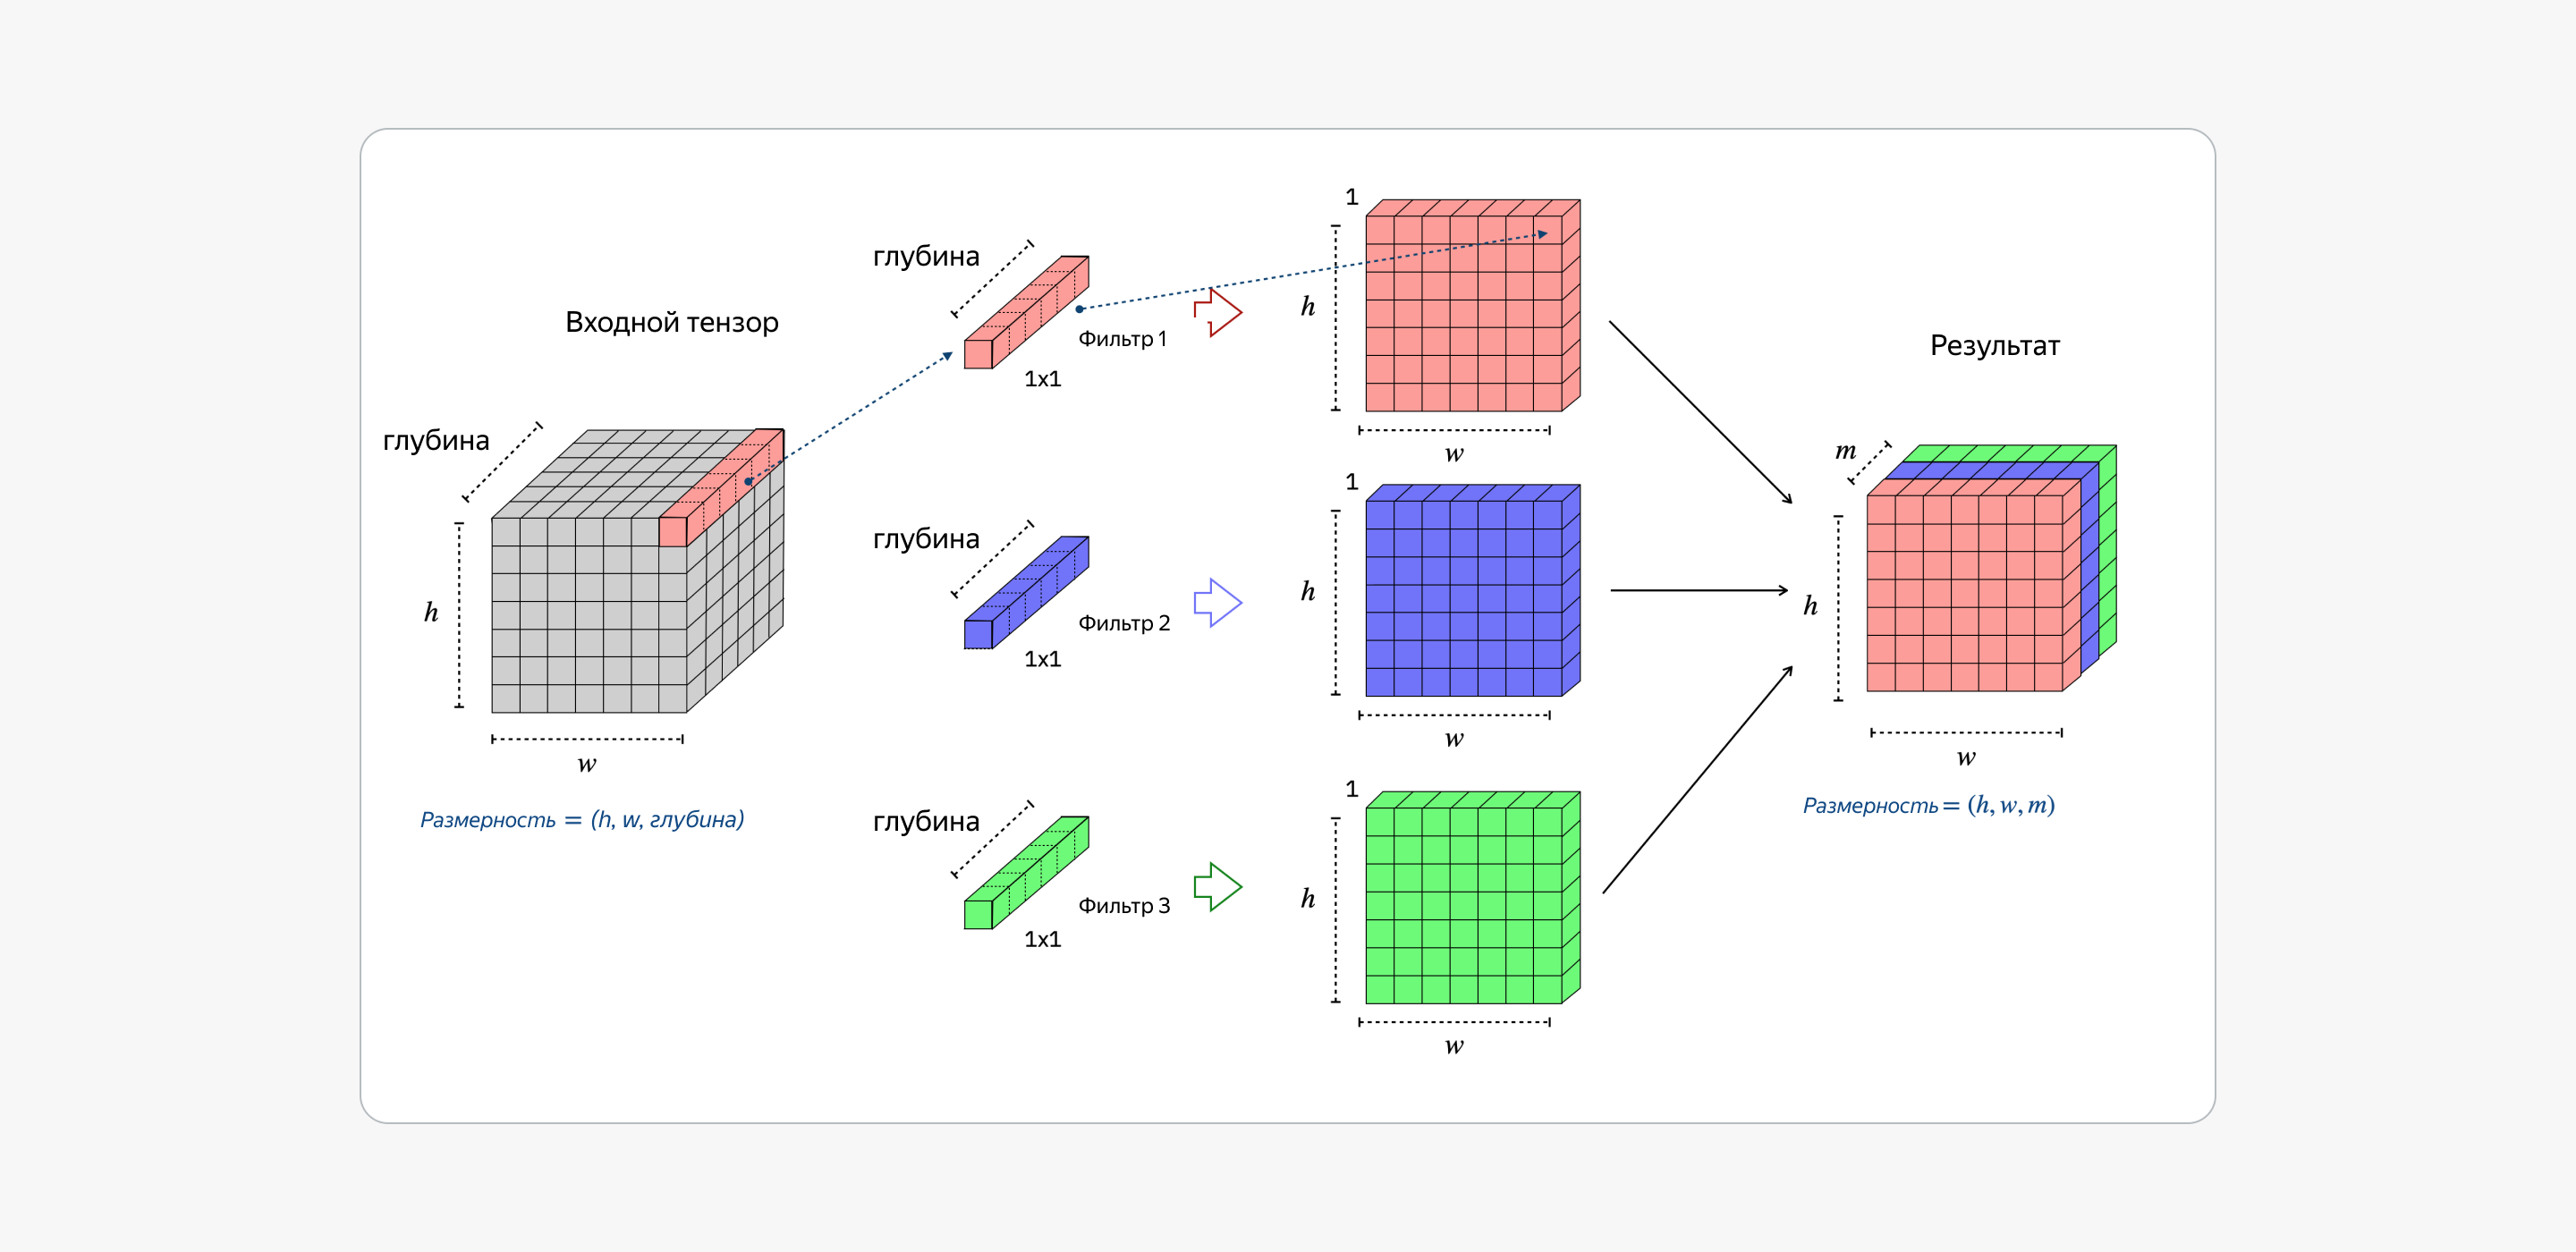

In [7]:
from IPython.display import Image
from ml_dl_experiments import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/point_cnn.png"
Image(path_to_image, width=900, height=900)

Cвёрточные слои обучаемые, поэтому нейросеть найдёт способ свернуть тензор в компактную форму, а потом развернуть обратно, при этом не потеряв важные для решения задачи признаки. Слои точечной свёртки ответственны за сжатие и восстановление информации.

In [8]:
import torch.nn as nn
from torch import Tensor, conv2d

model = nn.Sequential(
    nn.Conv2d(
        in_channels=512,
        out_channels=48,
        kernel_size=1,
        padding='same'),
    nn.ReLU(),
    nn.Conv2d(
        in_channels=48,
        out_channels=48,
        kernel_size=3,
        padding="same"
    ),
    nn.ReLU(),
    nn.Conv2d(
        in_channels=48,
        out_channels=512,
        kernel_size=1,
        padding="same"
    )
)

print('Количество параметров: ', sum(p.numel() for p in model.parameters()))

Количество параметров:  70496


## Batch normalization and DenseNet

Нейронные сети и любые другие модели, обучаемые с помощью градиентного спуска, лучше обучаются на нормализованных данных — в которых входные признаки приведены к одному масштабу. 

Нормализация помогает ускорить обучение, потому что в базовом градиентном спуске optim.SGD для коррекции всех весов используется одинаковый параметр скорости обучения. Это значит, что в течение одной итерации обучения все веса увеличиваются или уменьшаются на значения примерно одного порядка. 

Без нормализации входные признаки имеют разные масштабы: один — десятки, другой — тысячи. Эти признаки умножаются на веса, которые должны компенсировать это различие. В результате признаки равноценно влияют на результат. Но порядки весов различаются и корректировать их с одной скоростью обучения сложно. Оптимальная для одного веса скорость будет слишком низкой для другого. Нормализация как раз помогает этого избежать.

Механизм Batch Normalization
Чтобы решить проблему внутреннего сдвига, появилась идея Batch Normalization. Её суть в том, чтобы нормализовать не только признаки — входные данные первого слоя, но и активации — входные данные последующих слоёв. Так как признаки в изображениях — это 2D карты признаков, используется 2D версия Batch Normalization.

Всё рассмотренное выше касается не только первого слоя нейросети, но и всех последующих. А нормализуются при этом только входные признаки. Оказывается, проходя через слои нейросети и функции активации, признаки постепенно перестают быть нормализованными, распределение начинает смещаться. Это явление называют внутренним ковариационным сдвигом.

В сравнении со стандартной ситуацией это выглядит так:

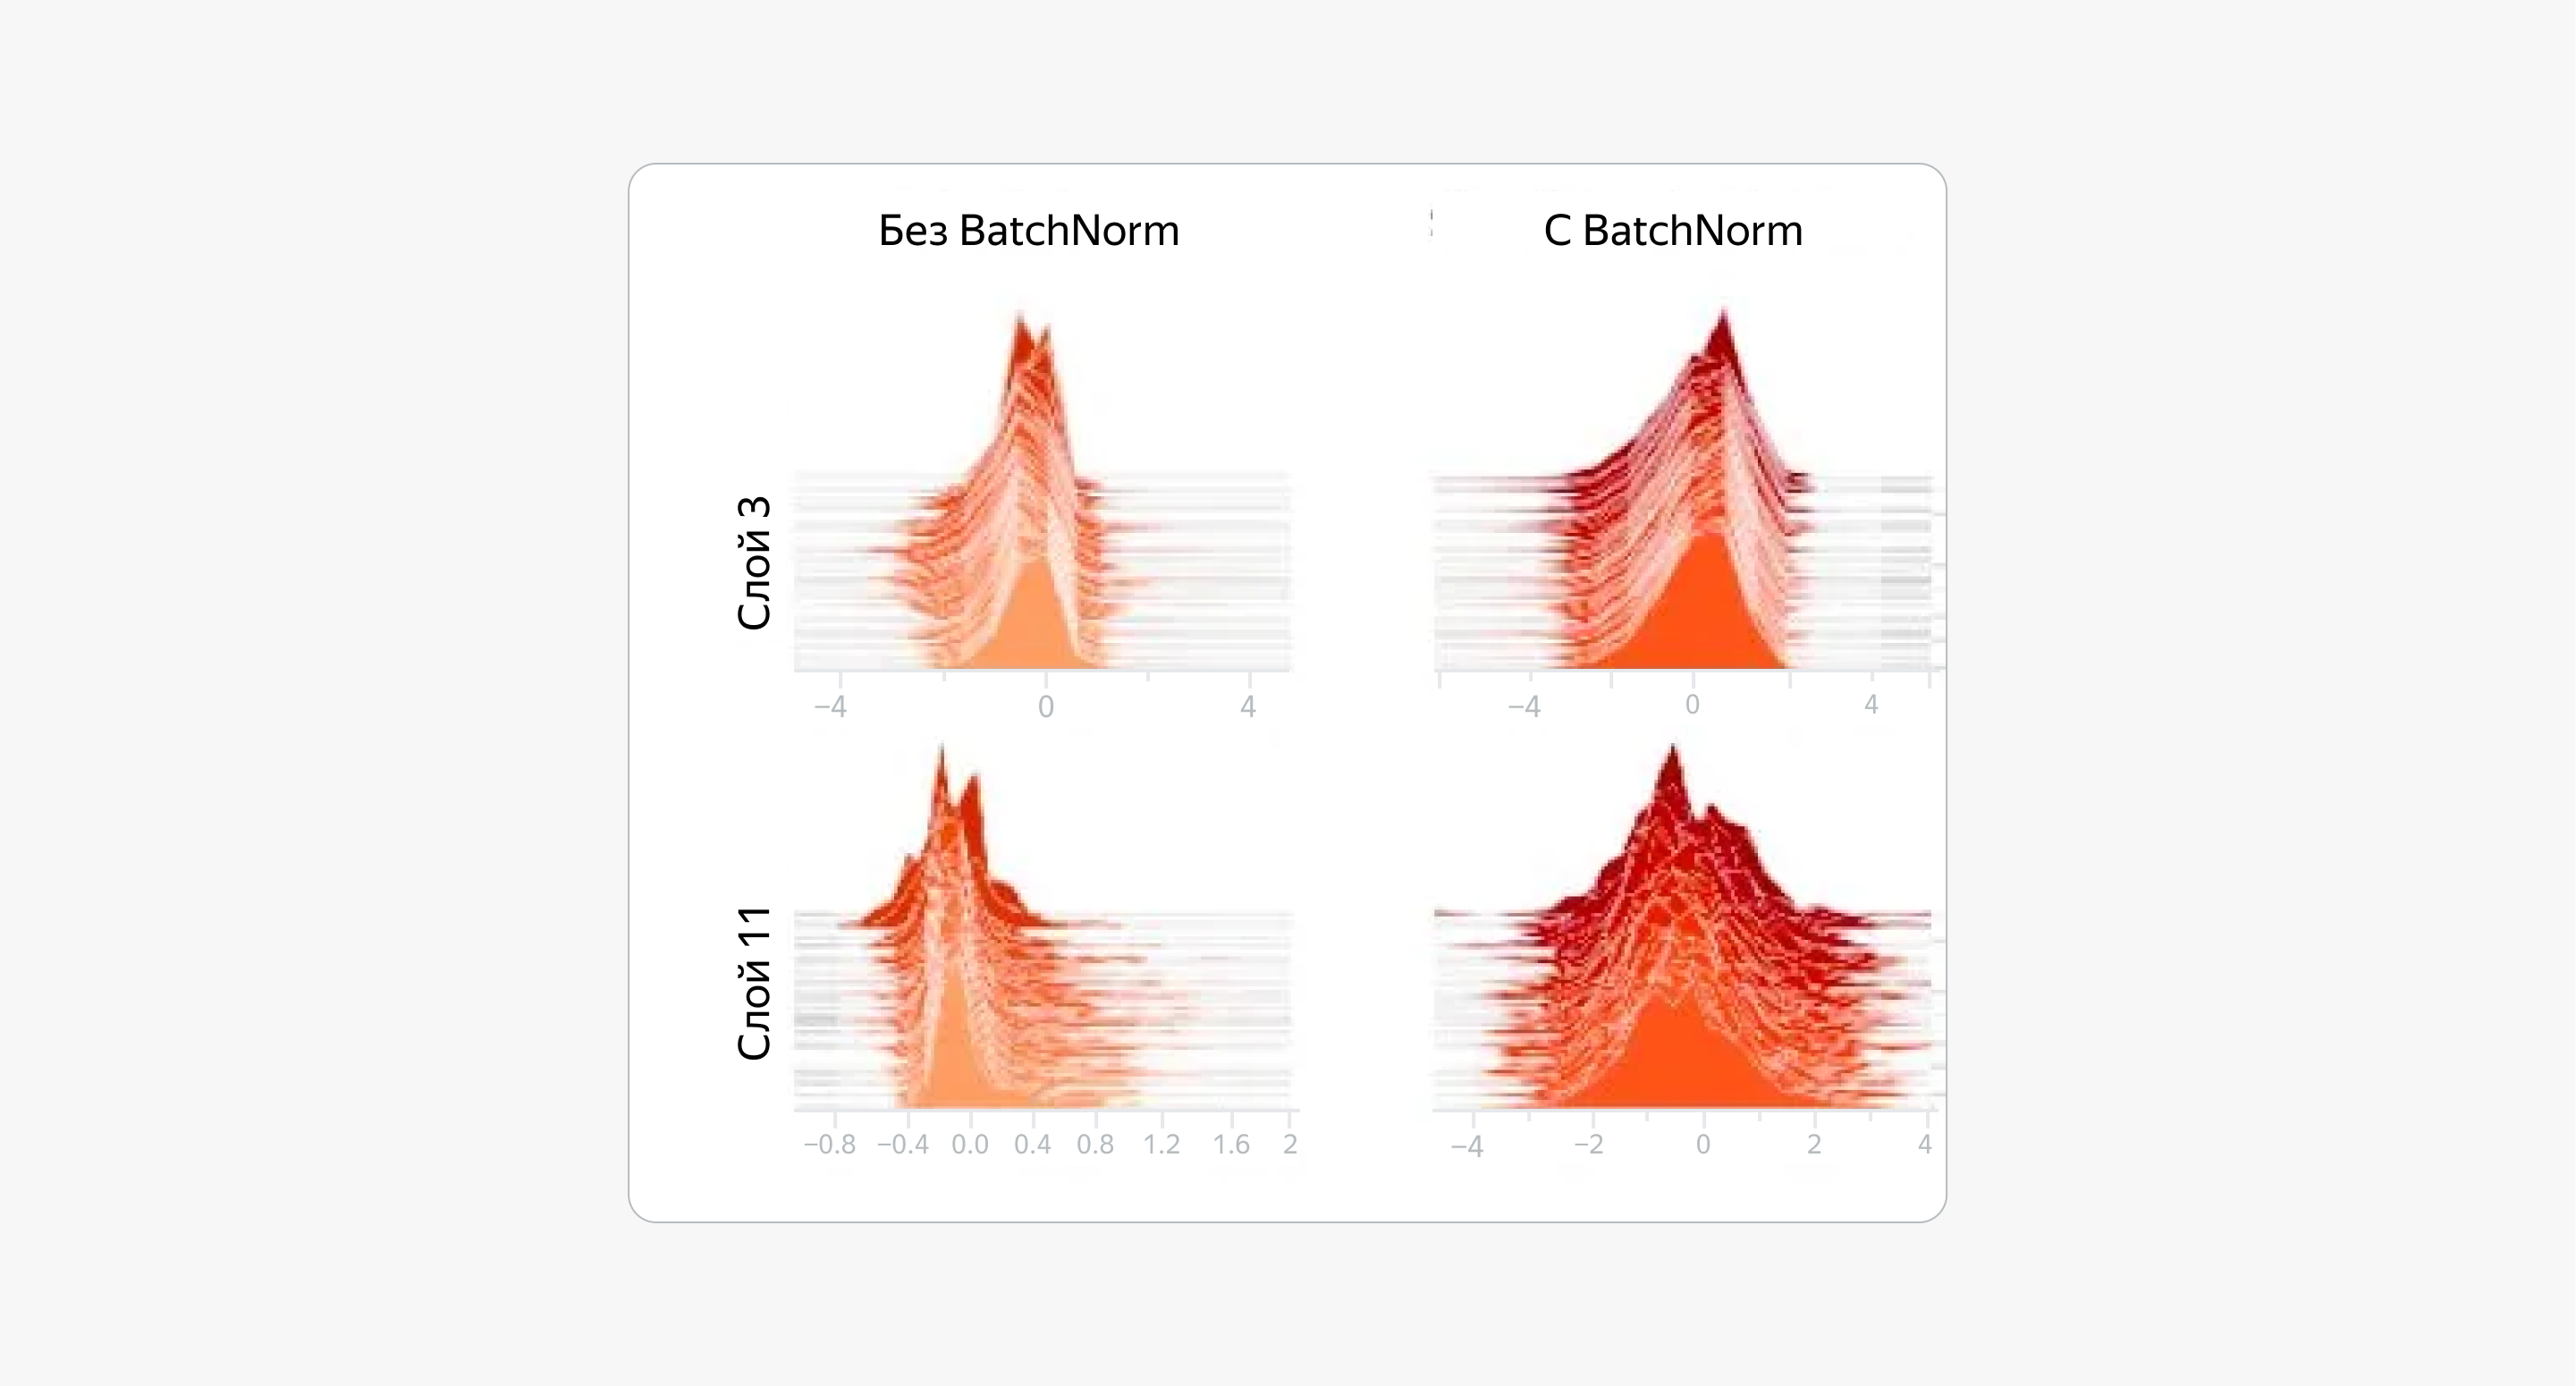

In [9]:
from IPython.display import Image
from ml_dl_experiments import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/cov_shift.png"
Image(path_to_image, width=900, height=900)

Слой nn.BatchNorm2D располагается между другими слоями и обеспечивает нормализацию в пределах батча. Если батч — это четырёхмерный тензор вида [W, H, C, N], где C — это количество каналов или карт признаков, а N — количество изображений в батче, то нормализация будет производиться по оси C. Например:

- Из каждого входного изображения (всего их N) после обработки свёрточным слоем получается C карт признаков, в каждой WxH значений.
- Нужно взять первую карту признаков для каждого изображения. Получится WxHxN чисел.
- Далее нужно нормализовать эти WxHxN чисел, для этого:
    
    - посчитать для них среднее арифметическое;
    
    - посчитать для них стандартное отклонение;
        
    - вычесть из каждого числа среднее и разделить на стандартное отклонение.

Повторить для второй карты признака каждого изображения, третьей и так далее.

Формула нормализации для набора первых карт признаков X с размерностью $[W*H*N]$:
$$
X_{norm​}=\frac{X−mean}{std}
$$
Где $mean$ — среднее, 

$std$ — стандартное отклонение.

В результате получится нормализованный тензор $X_{norm​}$ со средним = 0 и стандартным отклонением = 1.

## Параметры Batch Normalization

Во время обучения информация о среднем значении и стандартном отклонении каждой карты признака сохраняется в слое Batch Normalization. Они подсчитываются как скользящее среднее(Скользящее среднее — это взвешенная сумма текущего значения и предыдущего скользящего среднего. Это менее точная величина, чем арифметическое среднее, но она вычисляется эффективнее.), обновляясь после каждого батча.

Во время использования нейросети эти значения уже не обновляются — применяются те, что были рассчитаны на этапе обучения.

Именно из-за расчёта параметров нормализации методом скользящего среднего, а не точного арифметического, батч-нормализация часто упоминается как способ борьбы с переобучением.

В результате применения батч-нормализации не получится идеально нормализованный вектор со средним 0 и стандартным отклонением 1, реальные значения будут незначительно отклоняться за счёт неточных параметров нормализации. Так в данных появляется немного шума, и это помогает нейросети не зазубривать данные — не переобучаться.

Помимо среднего и стандартного отклонения, в слое Batch Normalization сохраняются ещё два параметра для каждой карты признака — гамма и бета. Это обучаемые параметры, которые сдвигают распределение нормализованного признака.

После нормализации все карты признаков будут иметь среднее, примерно равное 0, и стандартное отклонение, примерно равное 1. Однако для расчёта в последующих слоях, возможно, нужны другие масштабы, например, распределение со средним около 5 и стандартным отклонением около 3. Тогда гамма и бета сдвигают полученное распределение. По сути, гамма — это новое стандартное отклонение, а бета — новое среднее. Формула преобразования:
$$
X_{final​}=X_{norm}​⋅γ+β.
$$
Итого из изначального распределения значений карты признака по всем изображениям — , получится нормализованное $X_{final}$​ со стандартным отклонением $γ$ и средним $β$. Все обучаемые параметры слоя батч-нормализации — это вектора длины C, то есть их должно быть столько же, сколько карт признаков.

Гамма и бета обучаются, как и веса других слоёв, чтобы точность итоговой модели была максимальна.

## Современный свёрточный блок

Свёрточный блок в общем виде — это последовательность операций свёртки или свёртки и пулинга. Свёрточные блоки, применяемые в современных нейросетях, различаются тем, что содержат ещё и слой батч-нормализации. К примеру, полноценный блок ResNet выглядит так:

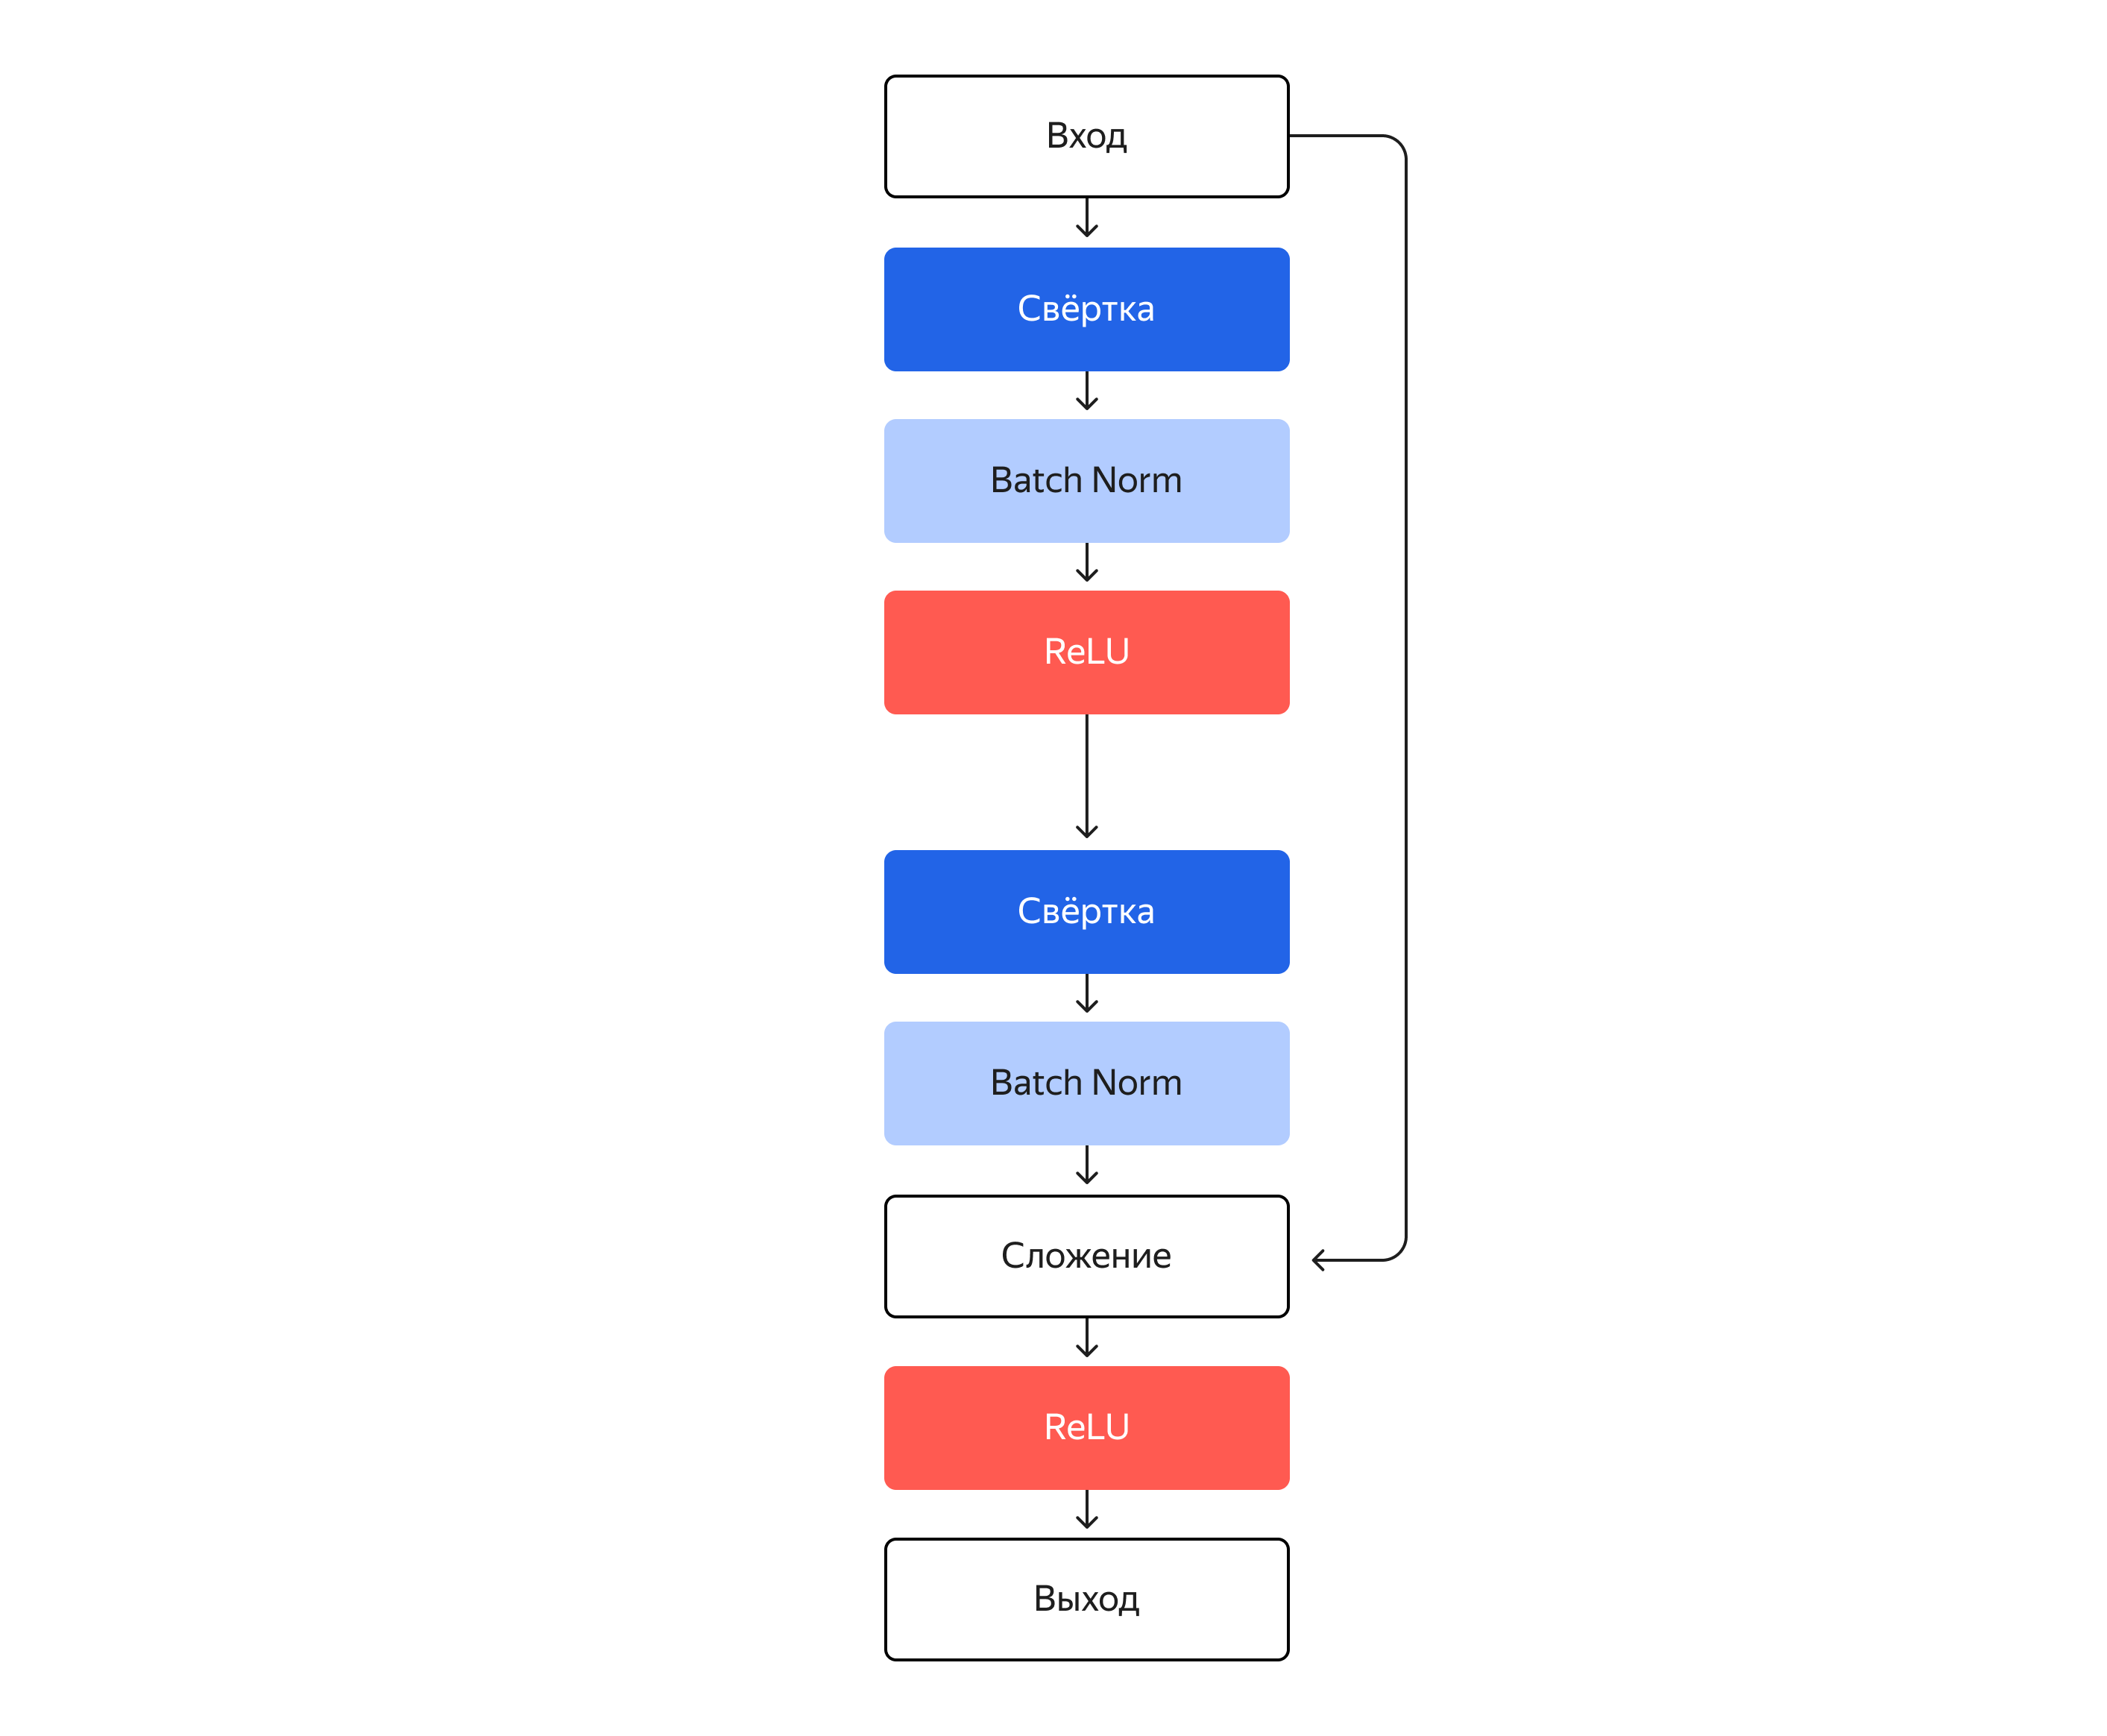

In [10]:
from IPython.display import Image
from ml_dl_experiments import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/bn_sc_block.png"
Image(path_to_image, width=900, height=900)

На схеме блок батч-нормализации располагается после свёрточного слоя, но перед функцией активации. В реальных архитектурах вы можете встретить ситуацию, когда батч-нормализация и функция активации меняются местами. 

Это связано с тем, что авторы батч-нормализации предлагали нормализовать активации. То есть можно предположить порядок:

1. Свёрточный слой.

2. Функция активации.

3. Батч-нормализация.

Но при этом в самих вычислениях в статье батч-норм располагается скорее перед функцией активации, поэтому в дальнейшем исследователи располагали слои и так тоже:

1. Свёрточный слой.
   
2. Батч-нормализация.

3. Функция активации.

И хуже не становилось. Есть спекуляции, что какой-то из этих вариантов лучше, но единого мнения с математическими доказательствами нет.

При переводе в код и с уточнёнными параметрами Residual блок со схемы выше выглядит так:

```python
import torch.nn as nn
from torch import Tensor


class ResidualBlock(nn.Module):

    def __init__(
        self,
        inputs: int,
        outputs: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 = nn.Conv2d(inputs,
                               outputs,
                               kernel_size=3,
                               stride=stride,
                               bias=False,
                               padding='same')
        self.bn1 = norm_layer(outputs)
        # Можно объявить один раз и реиспользовать,
        # так как в reLU нет обучаемых параметров
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(outputs,
                               outputs,
                               kernel_size=3,
                               stride=stride,
                               bias=False,
                               padding='same')
        self.bn2 = norm_layer(outputs)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out
```

Интересно, что в ResNet не используется Dropout, хотя ещё в VGG он был важным компонентом полносвязной части модели. Это происходит по двум причинам.

**Батч-нормализация сама по себе помогает предотвращать обучение.** Поэтому Dropout ей просто может быть не нужен.

**Иногда Dropout все-таки нужен, и тогда исследователи рекомендуют размещать его после всех слоёв батч-нормализации.** Если разместить Dropout перед батч-нормализацией, то во время обучения он будет отключать случайную часть активаций. Из-за этого он будет менять параметры распределения их значений, которые сохраняются как скользящие среднее и стандартное отклонение в слое BatchNorm. 

А при использовании обученной модели Dropout работать уже не будет, соответственно, параметры распределения активаций будут различаться, а BatchNorm сохранял и ориентировался на прежние — с Dropout. Из-за этого может упасть точность распознавания при тестировании модели. Поэтому Dropout при необходимости располагается только после слоя батч-нормализации, а для надёжности — после всех слоёв батч-нормализации.

In [11]:
from ml_dl_experiments.dl.dl_modules.CNN.bottleneck_block import BottleneckBlock

model = BottleneckBlock(256, 64, 256)
print("Архитектура блока:", model)
print("Количество параметров:", sum(p.numel() for p in model.parameters()))

Архитектура блока: BottleneckBlock(
  (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Количество параметров: 70784


In [1]:
from torchsummary import summary

from ml_dl_experiments.dl.dl_modules\
    .CNN.colored_image_classifier import Classificator

# Проверка
model = Classificator(10)
print("Количество параметров:", sum(p.numel() for p in model.parameters()))

# визуализация архитектуры при распознавании изображений размером 224х224х3
summary(model, input_size=(3, 224, 224),  device = 'cpu')

Количество параметров: 14730
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 16, 56, 56]           1,024
       BatchNorm2d-6           [-1, 16, 56, 56]              32
              ReLU-7           [-1, 16, 56, 56]               0
            Conv2d-8           [-1, 16, 56, 56]           2,304
       BatchNorm2d-9           [-1, 16, 56, 56]              32
             ReLU-10           [-1, 16, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]           1,024
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
  Bottlene

## DenseNet
Идеи ResNet о повторном использовании признаков получили своё развитие в DenseNet — нейросети, придуманной Гао Хуаном и его коллегами. Авторы представляют свою архитектуру так:

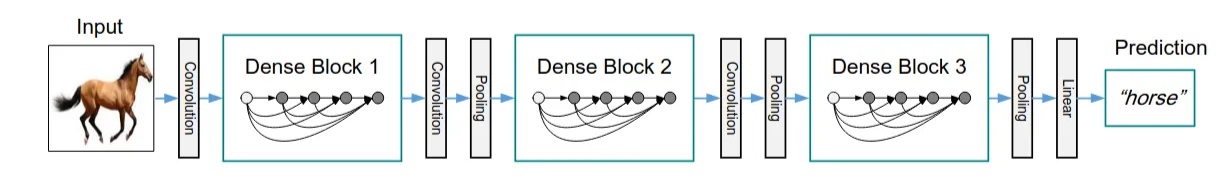

In [2]:
from IPython.display import Image
from ml_dl_experiments import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/DenseNet1.png"
Image(path_to_image, width=900, height=900)

Dense-блоки:

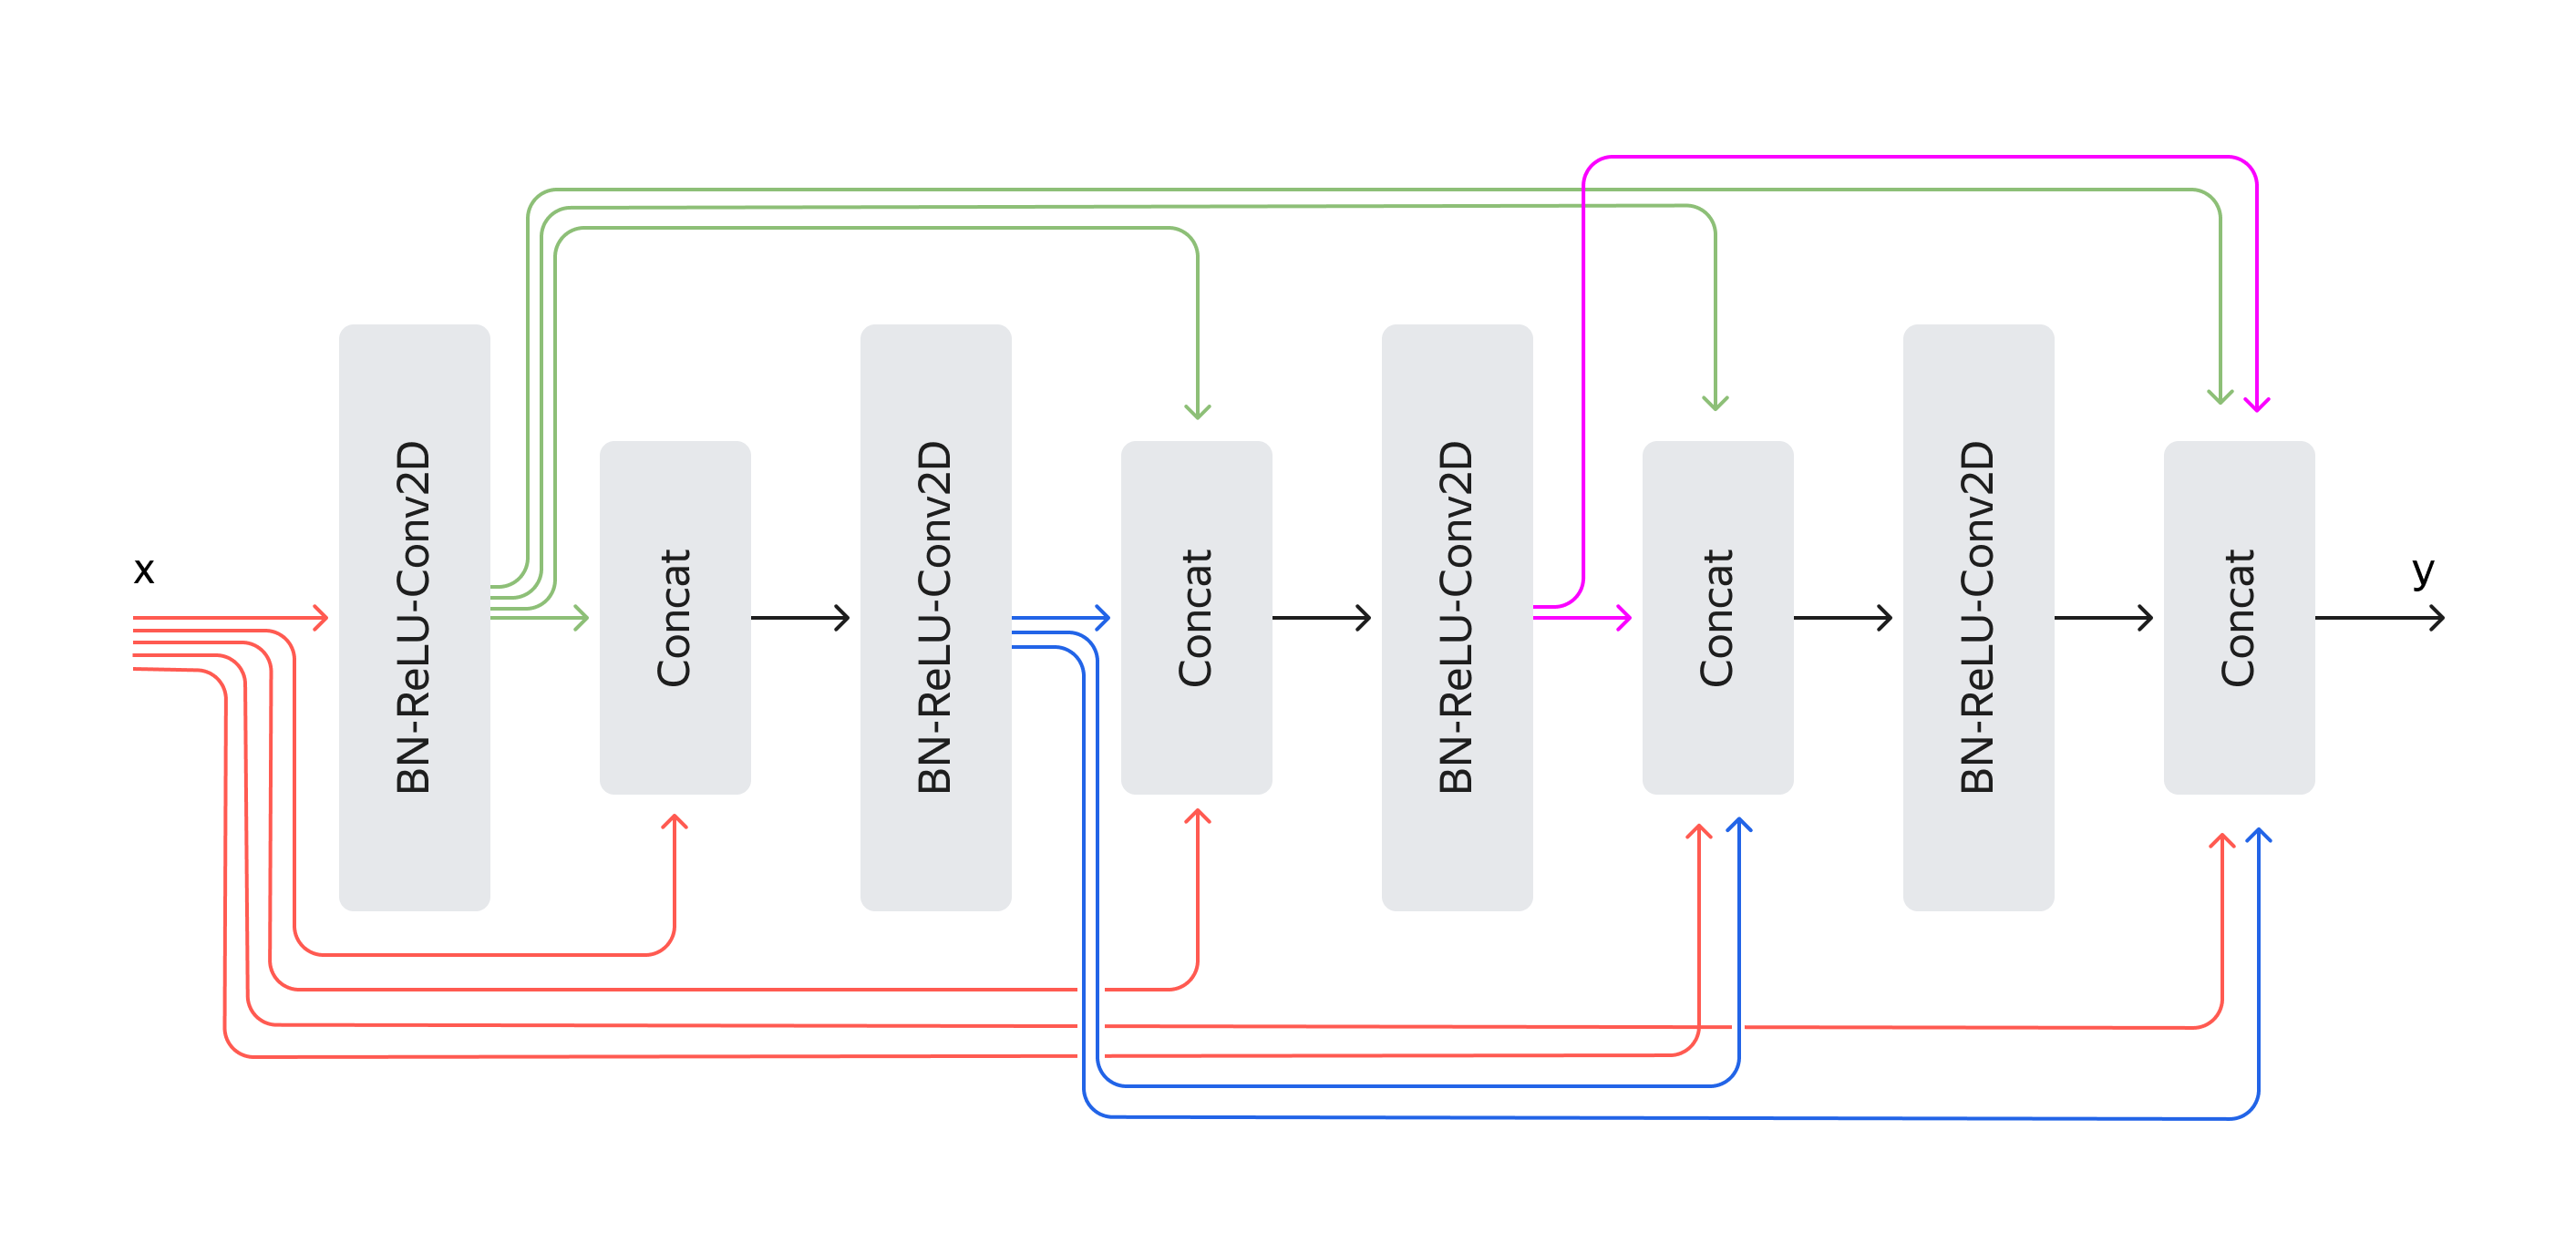

In [3]:
from IPython.display import Image
from ml_dl_experiments import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/Dense_block.png"
Image(path_to_image, width=900, height=900)

| Особенности               | ResNet                                                                                                                               | DenseNet                                                                                                                                                          |
|---------------------------|--------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Повторное использование признаков | В ResNet одни и те же признаки используются два раза:<br>1. В ветке обработки свёрточными блоками.<br>2. В ветке skip-connection.          | В DenseNet признаки реиспользуются много раз. К примеру, на схеме выше входной признак `X`:<br>1. Используется в первом блоке свёртки.<br>2. Присоединяется к обработанной версии через skip-connection.<br>3. Используется во втором блоке свёртки.<br>4. И так далее до самого конца dense-блока. |
| Ветвления                 | В ResNet ветки сливаются обратно в одну операцией **сложения** (`+`).                                                                | В DenseNet разветвления сливаются обратно через **конкатенацию** (`concat`).<br>Конкатенация происходит по оси глубины: два тензора размера `[W, H, C]` объединяются в тензор `[W, H, 2C]`. |

Получается, что если в ResNet карты признаков до и после обработки суммировались, то в DenseNet карты признаков до и после обработки просто накапливаются в одну стопку. И на выходе из Dense-блока получается очень много карт признаков с одинаковой площадью W×H.

Именно поэтому на общей схеме DenseNet между dense-блоками есть последовательности свёртка+пулинг. Их называют «переходные слои», они нужны для уменьшения площади и количества карт признаков между dense-блоками, чтобы контролировать быстрый рост числа параметров внутри dense-блоков. 

Под свёрткой здесь понимается точечная свёртка 1×1, она уменьшает количество карт признаков. Пулинг используется для уменьшения площади карт признаков.

Завершение модели такое же, как у ResNet, — глобальный пулинг и полносвязный слой для классификации.

Итого в DenseNet есть три основные новации:

- **Рост числа параметров.** В DenseNet ещё больше блоков и сами блоки теперь тоже состоят из блоков.
    
- **Ещё больше переиспользования признаков через дополнительные skip-connections.** Передача градиента в DenseNet происходит ещё проще за счёт обилия связей.
    
- **Конкатенация вместо суммирования** — теперь признаки не сливаются в одно обобщённое представление, а конкатенируются.

Эти нововведения также позволили немного увеличить точность в сравнении с ResNet.

# Облегченные архитектуры CNN

Если распознавание нужно запускать на офисном компьютере без видеокарты или смартфоне, то важнее, чтобы нейросеть работала, и уже во вторую очередь, чтобы работала хорошо. То же касается распознавания в режиме реального времени: нужна нейросеть, которая будет успевать обработать каждый поступивший кадр, её точность — важный, но второстепенный вопрос.

## MobileNet

MobileNet — это мобильная архитектура, то есть предназначена для использования на клиенте, а не на серверных мощностях. Если посмотреть на её архитектуру, то она почти ничем не отличается от прочих современных CNN. Состоит из:

- свёрточных блоков;
  
- глобального пулинга;

- полносвязного слоя для классификации.

В сравнении с ResNet и DenseNet блоков не так уж много:

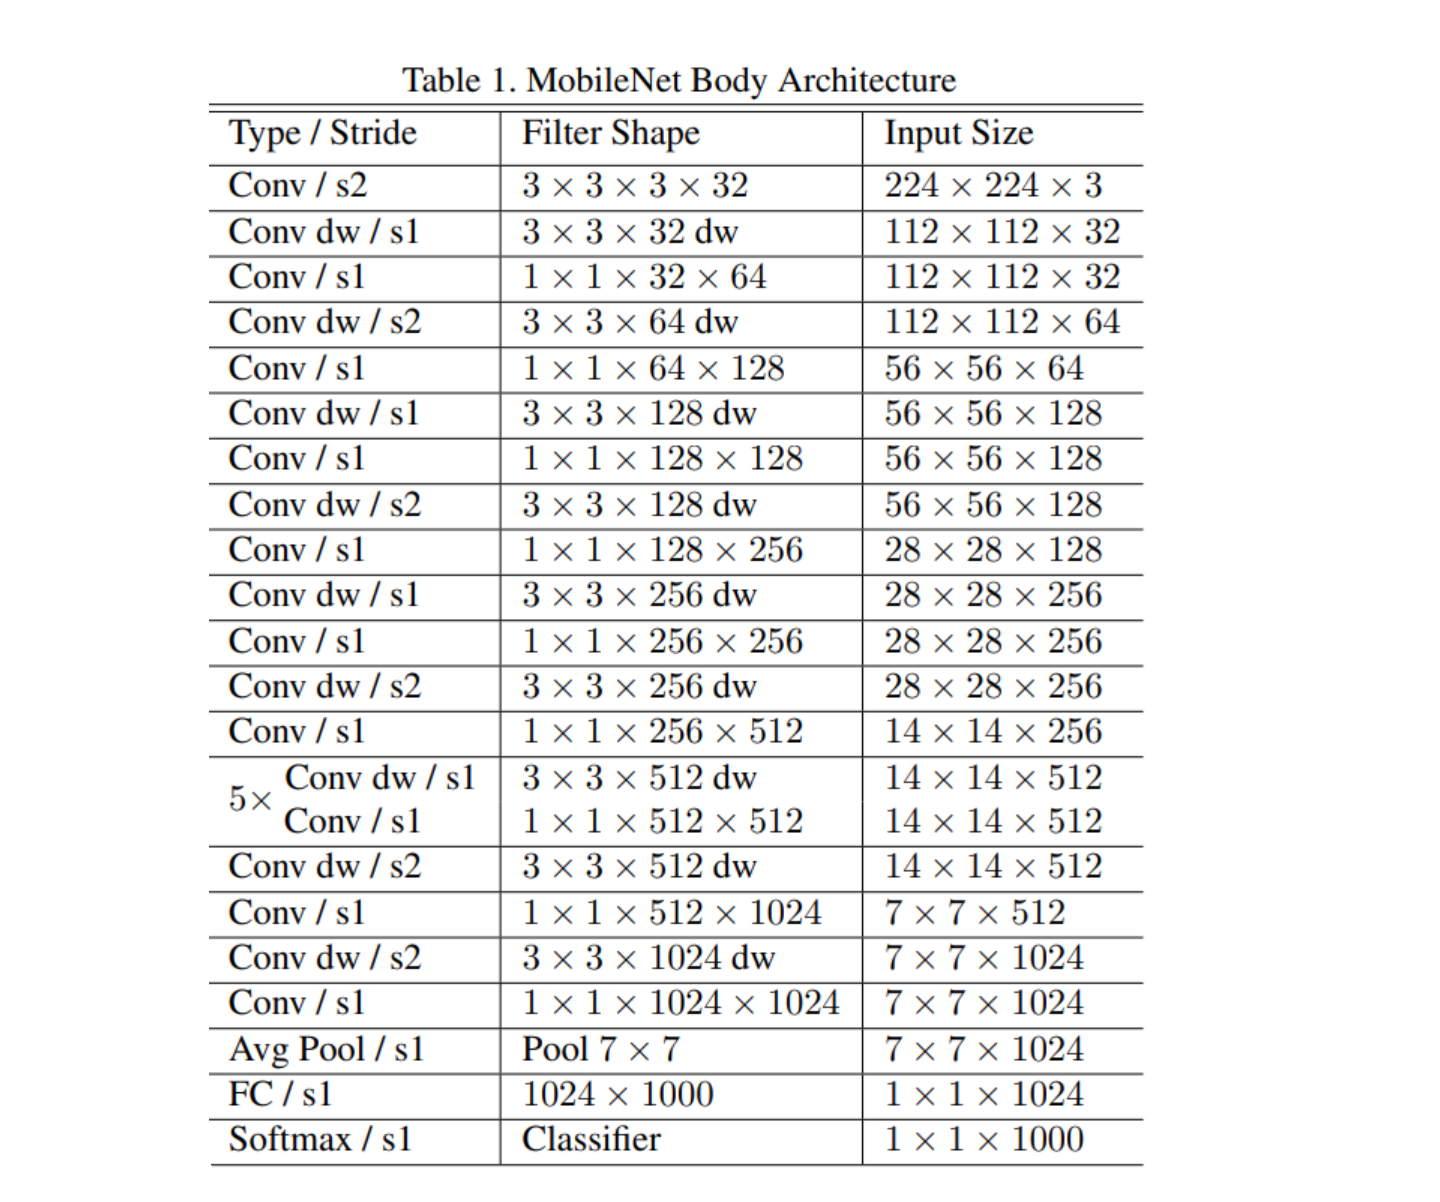

In [4]:
from IPython.display import Image
from ml_dl_experiments import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/mobilenet_arch.png"
Image(path_to_image, width=900, height=900)

Здесь есть Conv-блоки и некие Conv dw-блоки. В сравнении они выглядят так:

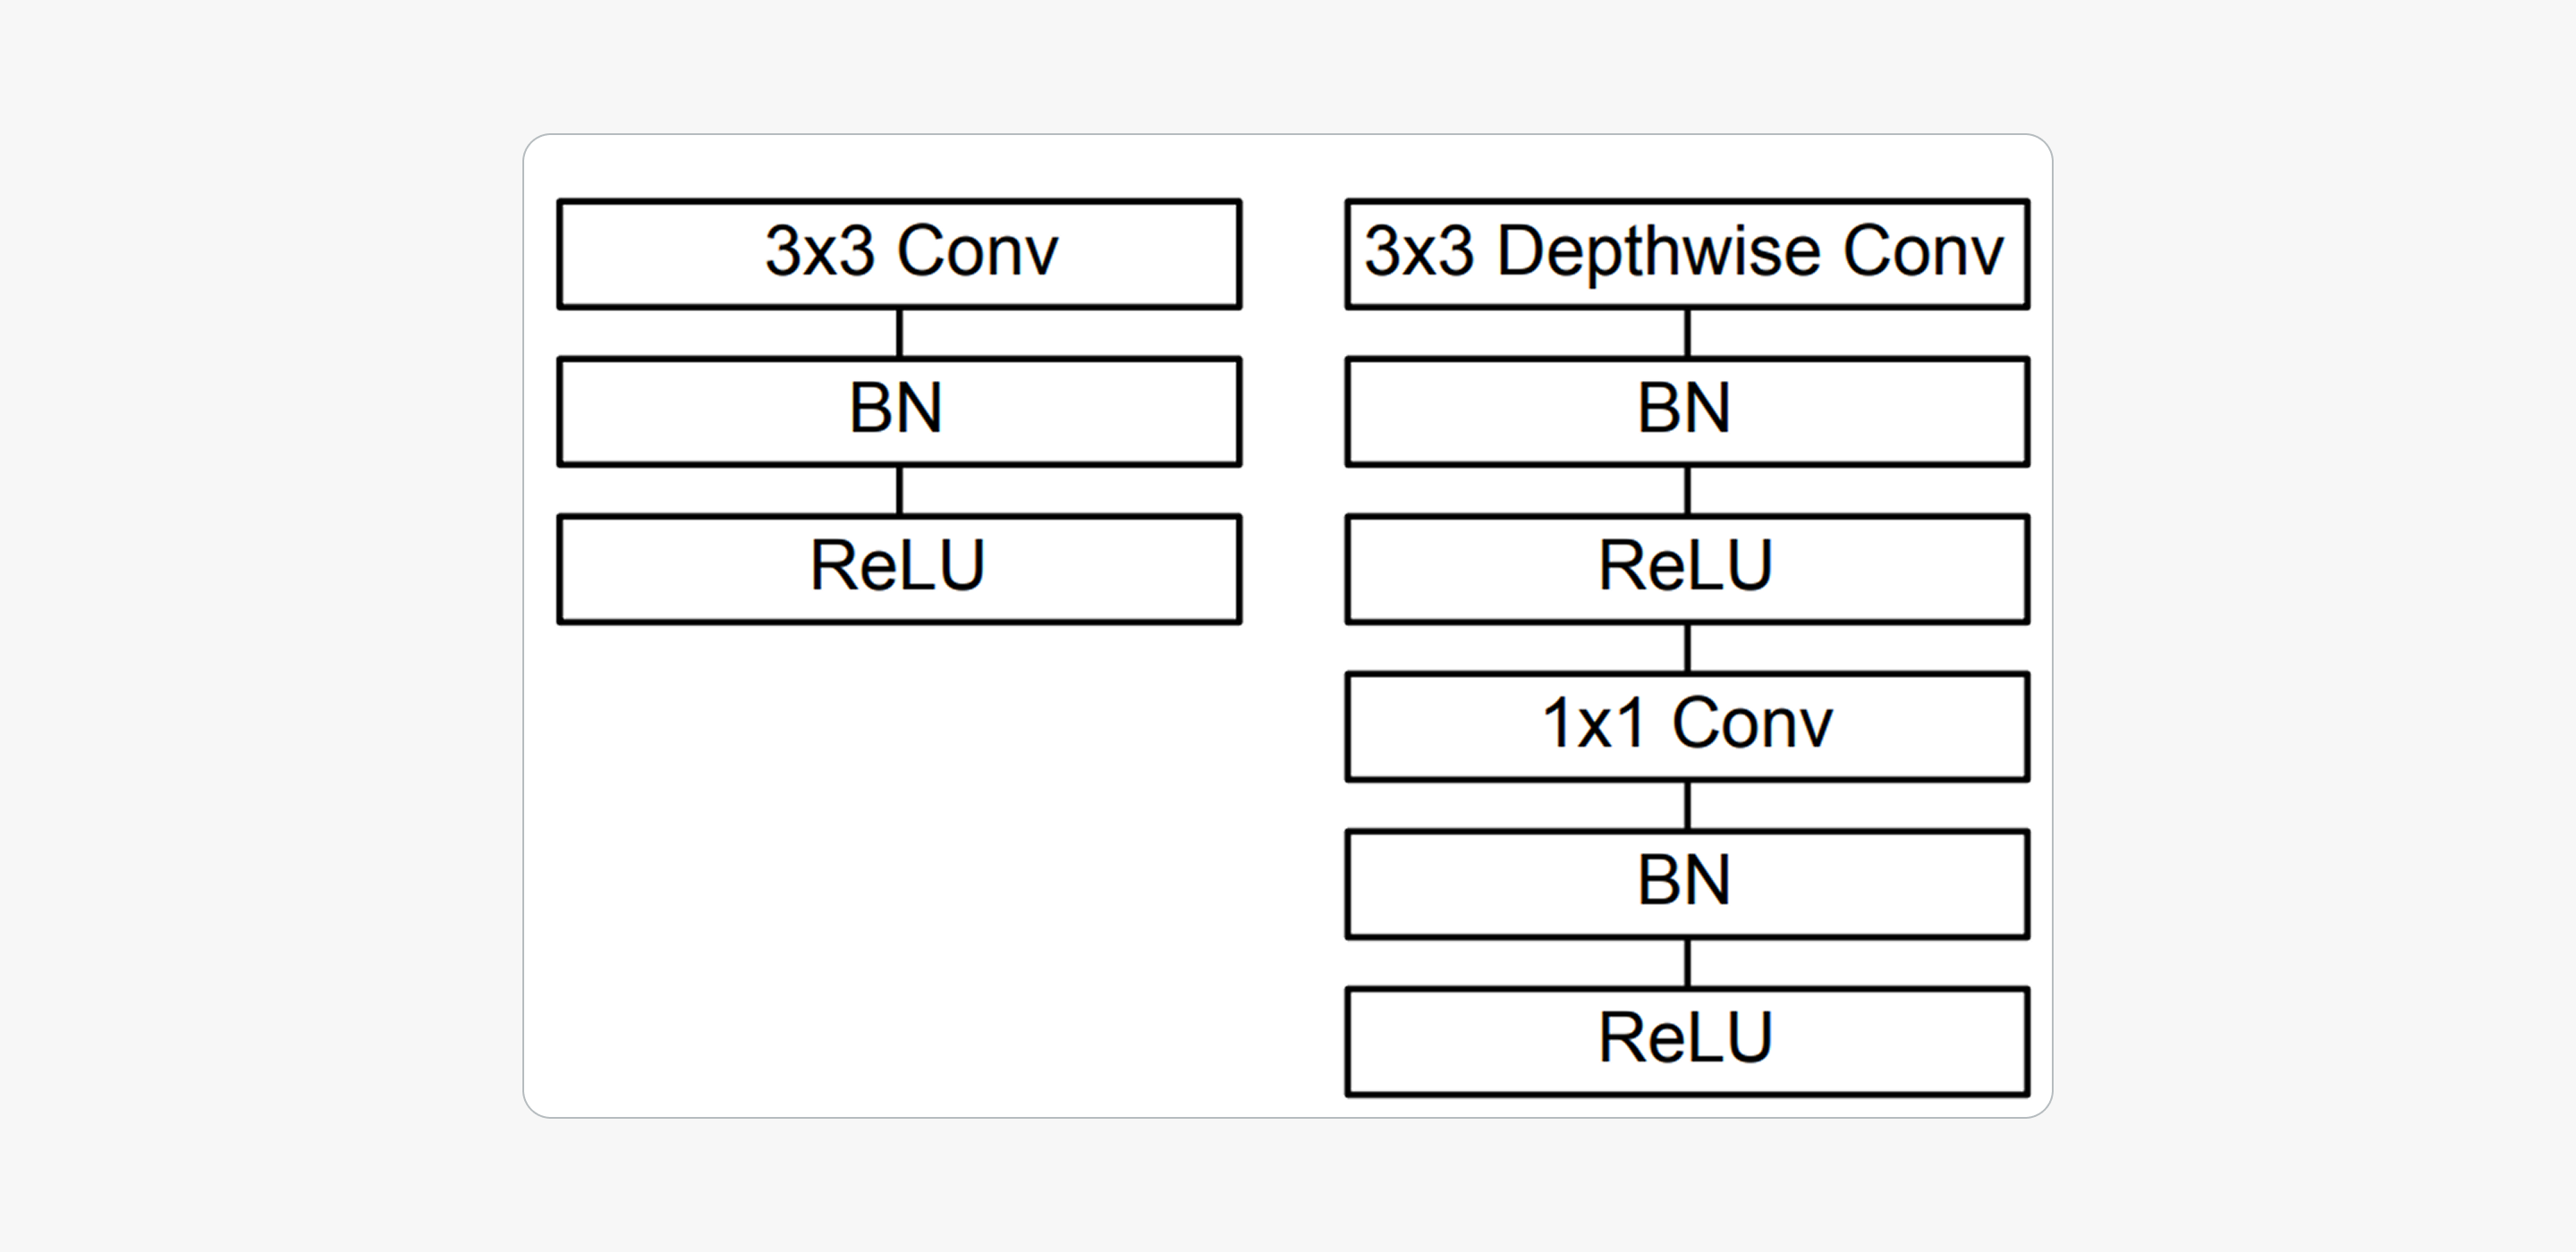

In [5]:
from IPython.display import Image
from ml_dl_experiments import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/convdw.png"
Image(path_to_image, width=900, height=900)

- Левый блок — точно такие же используются в ResNet и DenseNet как часть residual блоков.  

- Правый блок — это и есть основная новация MobileNet, которая позволяет этой архитектуре работать быстрее и весить меньше. Такой блок называется Conv dw или Depth-Wise Separable Convolution — грубо говоря, свёртка, разделяемая по глубине.

Чтобы понять, в чём преимущества такой свёртки, нужно познакомиться с её механизмом. Идея depth-wise separable свёртки в том, чтобы разделить стандартную операцию свёртки на два этапа:

- Свёртка каждого канала — depth-wise-свёртка.
  
- Свёртка по всем каналам — pointwise (точечная) свёртка.


1. **На этапе depth-wise-свёртки**. Здесь случается следующее:

- Входной тензор разделяется на каналы.
  
- Каждый канал отдельно обрабатывается свёрткой k×k (например, 3×3) с одним фильтром.
    
- Получается столько же карт признаков, сколько было каналов в исходном тензоре.

К примеру, если на входе было цветное изображение, то каждый из трёх каналов будет обработан отдельно собственным фильтром. В результате получится три карты признаков: для красного, синего и зелёного каналов соответственно.

Это похоже на не доведённую до конца стандартную nn.Conv2d свёртку с одним нейроном. В ней тоже каждый канал обрабатывается своим фильтром, только в конце карты для всех каналов суммируются в итоговую карту признака. В depthwise-свёртке этого суммирования нет, карты для каждого канала так и остаются отдельными.

2. **На этапе pointwise-свёртки.** Операция pointwise-свёртки уже знакома вам по bottleneck-блокам, где она использовалась для сжатия и восстановления глубины тензоров. Здесь её механизм абсолютно такой же:

- Входной тензор с M карт признаков обрабатывается свёрткой 1×1 с N фильтрами.
  
- Получается N новых карт признаков.

К примеру, если на вход поступили три карты признака и они были обработаны шестью нейронами свёртки 1×1, то на выходе получится 6 новых карт признака.
Визуально схема этой двухэтапной свёртки выглядит так:

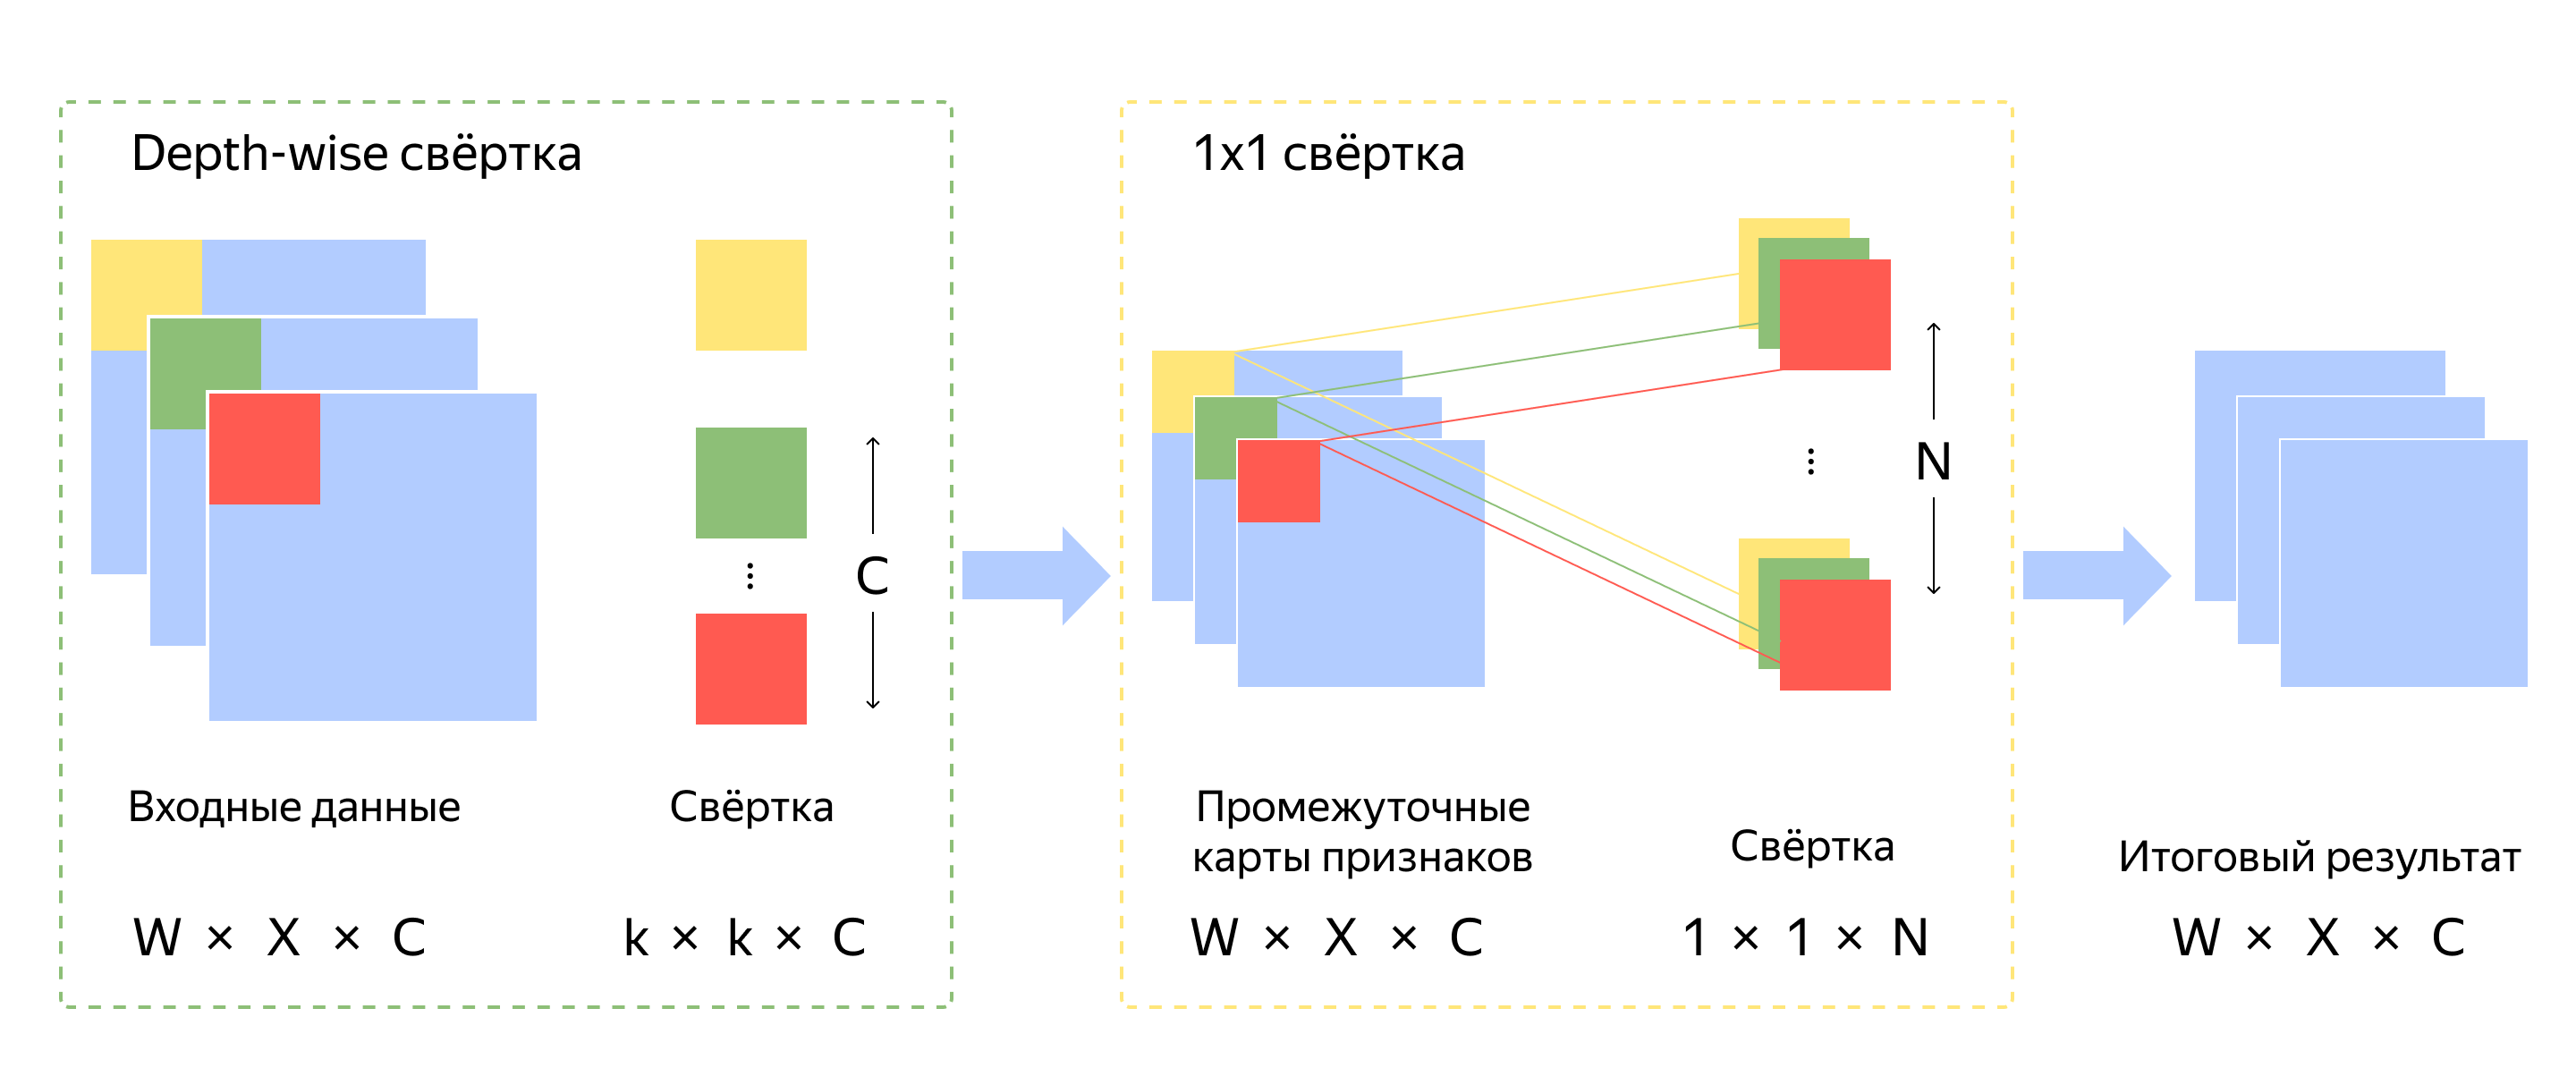

In [6]:
from IPython.display import Image
from ml_dl_experiments import settings

path_to_image: str = settings.SOURCE_PATH + "ml_dl/CNN/convdw_scheme.png"
Image(path_to_image, width=900, height=900)

Замысел этой свёртки состоит в том, что, если представить её как чёрный ящик, она успешно имитирует стандартную свёртку nn.Conv2d: на входе тензор W×H×3 → на выходе тензор W×H×64.

Это похоже на то, что цветное изображение W×H×3 было обработано свёрткой с 64 нейронами и на выходе получено 64 карты признака.
И происходящие внутри операции тоже имитируют стандартную свёртку:

- На depth-wise этапе анализируется присутствие какого-нибудь признака в каждом из 3 каналов.
  
- На pointwise-этапе уже по обобщённой информации со всех каналов происходит поиск конкретных 64 признаков.

Depth-wise-свёртка реализована в PyTorch параметром groups в nn.Conv2d. Чтобы осуществить depth-wise-свёртку, нужно задать параметр groups равным количеству каналов входного тензора. Например, depth-wise-свёртка цветного изображения:

```py
from torch import nn

depthwise = nn.Conv2d(3, 3, kernel_size=3, padding='same', groups=3) 
```

ReLU и батч-нормализация используются после каждого этапа. То есть в одной depth-wise-свёртке используются два ReLU и два батч-норм.
Конечно, эта свёртка не настолько же точная, как nn.Conv2d, потому что информация по каждому из каналов обобщается на depth-wise этапе, а на pointwise этапе анализ происходит окном 1×1. Однако такое разделение позволяет сильно сэкономить на количестве параметров и, соответственно, операций.